In [2]:
import re
import os
import ast
import mdpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Crear los archivo de metricas

In [8]:
# interceptamos las respuestas reales contra las predichas
df = pd.read_excel("ignorar/comprar_resultados.xlsx")
df['columnas realidad'] = df['columnas realidad'].apply(ast.literal_eval)
df['columnas ejecuciones'] = df['columnas ejecuciones'].apply(ast.literal_eval)

for i, fila in df.iterrows():
    if not fila['ejecutar']:
        continue
    respuesta_real = pd.DataFrame()
    
    with open(fila['archivo realidad'],'r') as f:
        contenido:str = f.read()
        inicio = contenido.find("INFO: resultado: '''") - len("INFO: resultado: '''") - 1
        fin = contenido.find(" '''\nWARNING: }") - 1
        
        respuesta_real = mdpd.from_md(contenido[inicio : fin])
    
    respuestas_predichas = []
    with open(fila['archivo ejecuciones'], 'r') as f:
        contenido:str = f.read()
        
        inicios = [inicio.end () for inicio in re.finditer("INFO: resultado: '''", contenido)]
        finales = [final.start() for final in re.finditer(" '''\nWARNING: }", contenido)]
        ejecuciones = [final.group(1) for final in re.finditer(r"INFO: tiempo: (\d*.\d*),", contenido)]
        for i in range(len(inicios)):
            respuestas_predichas.append(mdpd.from_md(contenido[inicios[i] + 1: finales[i]-1]))
    
    
    resultados = []
    
    for prediccion, tiempo in zip(respuestas_predichas, ejecuciones):
        
        resumen = {}
        resumen['Cantidad de respuestas esperadas'] = len(respuesta_real)
        resumen['Cantidad de respuesta predichas'] = len(prediccion) 
        resumen['Tiempo de ejecución'] = tiempo

        if prediccion.empty:
            prediccion = pd.DataFrame(columns=fila['columnas ejecuciones'])
        
        # Aqui procesaremos los datos de las predicciones por si tienen
        # algun caracter extraño. Caracteres extraños detectados:
        #    - \xa0: Un especie de espacio en blanco que no es el mismo caracter
        #            que el verdadero espacio en blanco
        
        tuplas_prediccion = []
        for record in prediccion.itertuples(index=False, name=None):
            tupla = []
            for i in range(len(fila['columnas ejecuciones'])):
                if isinstance(record[i], str):
                    tupla.append(record[i].replace(u'\xa0', u' '))
                else:
                    tupla.append(record[i])
                    
            tuplas_prediccion.append(tuple(tupla))
        
        tuplas_realidad = list(respuesta_real.itertuples(index=False, name=None))
        
        resumen['Cantidad de respuestas predichas que son correctas'] = len(set(tuplas_realidad).intersection(set(tuplas_prediccion)))
        resultados.append(resumen)   
    
    with open(fila['archivo resultado'], 'w') as f:
        for i, resultado in enumerate(resultados):
            f.write(f"\n@ Metricas de la ejecución {i+1}\n")
            f.write(f"metricas: {resultado}\n")

# Crear un archivo Excel con la precision y recall de cada ejecucion

In [9]:
# cargamos los queries
queries = pd.read_excel('./ignorar/queries_ejecutar_modificados.xlsx')['query'].to_list()
modelos = ['llama2-uncensored', 'llama3', 'gemma']
carpeta_metricas = 'resultados/metricas/queries'
metricas = ['precision', 'recall']

datos_precision = []
datos_recall = []
datos_no_respondieron = []

for metrica in metricas:
    for modelo in modelos:
        archivos = os.listdir(os.path.join(carpeta_metricas, modelo))
        for i, archivo in enumerate(archivos):
            with open(os.path.join(carpeta_metricas, modelo, archivo),'r') as f:
                contenido = f.read()
                resumenes = [ast.literal_eval(diccionario.group(1)) for diccionario in re.finditer(r'metricas: (.*)\n',contenido)]
            
            for j, resumen in enumerate(resumenes):
                nueva_fila = [queries[i], j + 1, modelo]
                
                if metrica == 'precision':
                    if resumen['Cantidad de respuesta predichas'] == 0:
                        datos_no_respondieron.append([queries[i], j + 1, modelo]) 
                    
                    if  resumen['Cantidad de respuesta predichas'] == 0:
                        nueva_fila.append(0)
                    else:
                        nueva_fila.append(round(resumen['Cantidad de respuestas predichas que son correctas'] / resumen['Cantidad de respuesta predichas'],2))
                        
                    nueva_fila.append(round(float(resumen['Tiempo de ejecución']), 3))
                    datos_precision.append(nueva_fila)
                elif metrica == 'recall':
                    nueva_fila += [round(resumen['Cantidad de respuestas predichas que son correctas']/ resumen['Cantidad de respuestas esperadas'], 2), round(float(resumen['Tiempo de ejecución']), 3)]
                    datos_recall.append(nueva_fila)


datos_precision_df = pd.DataFrame(datos_precision, columns=['query', 'nro.Ejecución', 'modelo', 'precision', 'tiempo'])
datos_recall_df = pd.DataFrame(datos_recall, columns=['query', 'nro.Ejecución', 'modelo', 'recall', 'tiempo'])
datos_no_respondieron_df = pd.DataFrame(datos_no_respondieron, columns=['query', 'nro.Ejecución', 'modelo'])

excel_writer = pd.ExcelWriter(os.path.join(carpeta_metricas, 'resumen.xlsx'))
datos_precision_df.to_excel(excel_writer, 'precision', index=False)
datos_recall_df.to_excel(excel_writer, 'recall', index=False)
excel_writer.close()

C:\Users\PC\AppData\Local\Temp\ipykernel_7320\2409818455.py:43: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  datos_precision_df.to_excel(excel_writer, 'precision', index=False)
C:\Users\PC\AppData\Local\Temp\ipykernel_7320\2409818455.py:44: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  datos_recall_df.to_excel(excel_writer, 'recall', index=False)


# Crear un archivo Excel con el promedio de la precision, recall y tiempo de cada query

In [18]:
# cargamos los queries
queries = pd.read_excel('./ignorar/queries_ejecutar_modificados.xlsx')['query'].to_list()
modelos = ['llama2-uncensored', 'llama3', 'gemma']
carpeta_metricas = 'resultados/metricas/ln'
metricas = ['precision', 'recall']

datos_precision_promedio = []
datos_recall_promedio = []

for modelo in modelos:
    for query in datos_precision_df['query'].unique():
        datos_precision_tiempo = datos_precision_df.loc[(datos_precision_df['modelo'] == modelo) & (datos_precision_df['query'] == query) & (datos_precision_df['precision'] != 0)]
        datos_recall_tiempo = datos_recall_df.loc[(datos_recall_df['modelo'] == modelo) & (datos_recall_df['query'] == query) & (datos_recall_df['recall'] != 0)]
                
        datos_precision_promedio.append([query, modelo, datos_precision_tiempo['precision'].mean(), datos_precision_tiempo['tiempo'].mean()])
        datos_recall_promedio.append([query, modelo, datos_recall_tiempo['recall'].mean(), datos_recall_tiempo['tiempo'].mean()])
        

datos_precision_promedio_df = pd.DataFrame(datos_precision_promedio, columns=['query', 'modelo', 'precision', 'tiempo'])
datos_recall_promedio_df = pd.DataFrame(datos_recall_promedio, columns=['query', 'modelo', 'recall', 'tiempo'])

excel_writer = pd.ExcelWriter(os.path.join('resultados/metricas/ln', 'resumen_promedio_ln.xlsx'))
datos_precision_promedio_df.to_excel(excel_writer, 'precision', index=False)
datos_recall_promedio_df.to_excel(excel_writer, 'recall', index=False)
excel_writer.close()

NameError: name 'datos_precision_df' is not defined

# Imprimir Diagramas de cajas

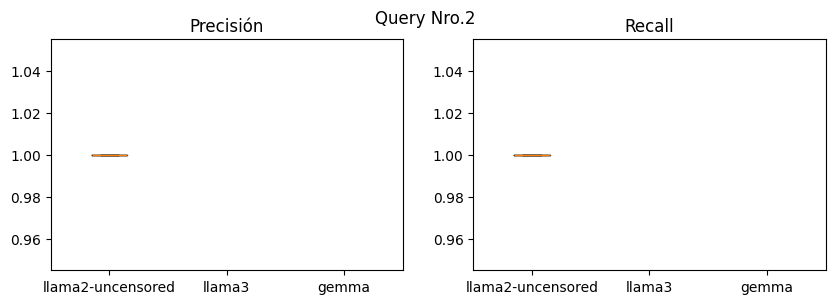

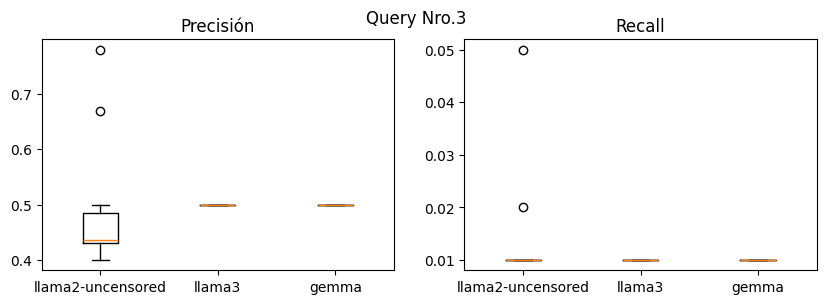

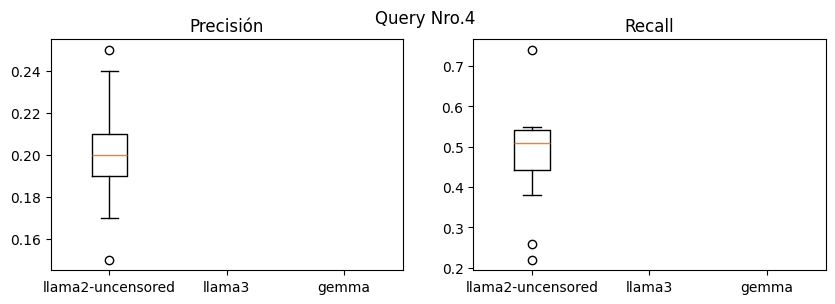

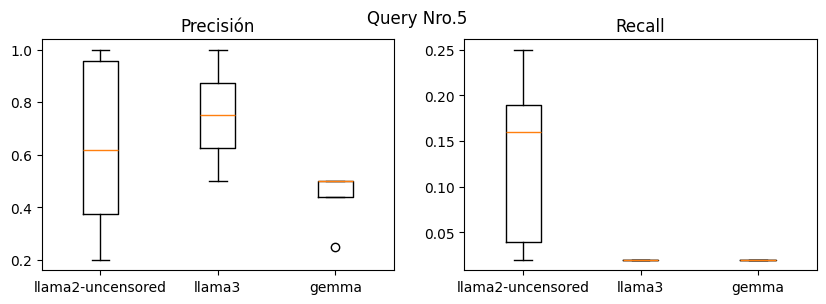

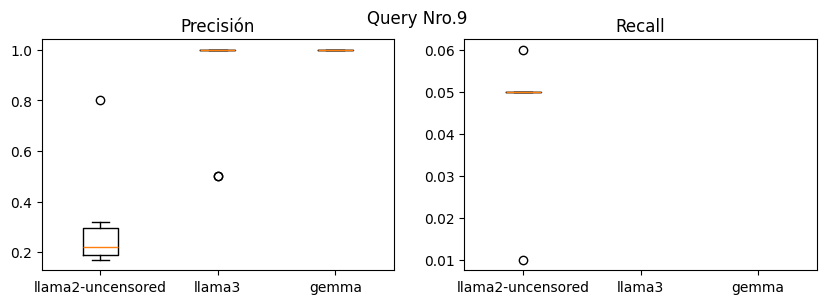

In [26]:
for i, query in enumerate(datos_precision_df['query'].unique()):
    data_precision = []
    data_recall = []
    for modelo in modelos:
        data_precision.append(datos_precision_df.loc[(datos_precision_df['modelo'] == modelo) & (datos_precision_df['query'] == query) & (datos_precision_df['precision'] != 0)]['precision'].to_list()) 
        data_recall.append(datos_recall_df.loc[(datos_recall_df['modelo'] == modelo) & (datos_recall_df['query'] == query) & (datos_recall_df['recall'] != 0)]['recall'].to_list()) 

    if data_precision !=[[],[],[]]: 
        fig, axs = plt.subplots(1,2,figsize=(10,3))
        fig.suptitle(f"Query Nro.{i+1}")
        axs[0].set_title('Precisión')
        axs[0].boxplot(data_precision, tick_labels=modelos)

        axs[1].set_title('Recall')
        axs[1].boxplot(data_recall, tick_labels= modelos)
        plt.show()

# Calculo de los queries cuyas ejecuciones dieron precision y recall igual o mayor a cero

In [14]:
def calcular_cantidad_precision_recall(direccion_archivo_resumen: str, modelos: list[str]):
    excel_file = pd.ExcelFile(direccion_archivo_resumen)

    datos_precision_df = excel_file.parse('precision')
    datos_recall_df = excel_file.parse('recall')
    
    precision_iguales_cero = {}
    precision_distintos_cero = {}
    recall_iguales_cero = {}
    recall_distintos_cero = {}

    for modelo in modelos:
        nueva_fila_precision_iguales_cero = []
        nueva_fila_precision_distintos_cero = []
        nueva_fila_recall_iguales_cero = []
        nueva_fila_recall_distintos_cero = []
        
        for query in datos_precision_df['query'].unique():
            nueva_fila_precision_iguales_cero.append(len(datos_precision_df.loc[(datos_precision_df['modelo'] == modelo) & (datos_precision_df['query'] == query) & (datos_precision_df['precision'] == 0)]))
            nueva_fila_precision_distintos_cero.append(len(datos_precision_df.loc[(datos_precision_df['modelo'] == modelo) & (datos_precision_df['query'] == query) & (datos_precision_df['precision'] != 0)]))
            
            nueva_fila_recall_iguales_cero.append(len(datos_recall_df.loc[(datos_recall_df['modelo'] == modelo) & (datos_recall_df['query'] == query) & (datos_recall_df['recall'] == 0)]))
            nueva_fila_recall_distintos_cero.append(len(datos_recall_df.loc[(datos_recall_df['modelo'] == modelo) & (datos_recall_df['query'] == query) & (datos_recall_df['recall'] != 0)]))

        precision_iguales_cero[modelo]= nueva_fila_precision_iguales_cero
        precision_distintos_cero[modelo]= nueva_fila_precision_distintos_cero
        recall_iguales_cero[modelo]= nueva_fila_recall_iguales_cero
        recall_distintos_cero[modelo]= nueva_fila_recall_distintos_cero 
    
    return precision_iguales_cero, precision_distintos_cero, recall_iguales_cero, recall_distintos_cero, datos_precision_df, datos_recall_df

# Funciones para graficar

In [2]:
def diagrama_barra_agrupados(datos, 
                            xlables: list[str], 
                            figsize: tuple[float, float], 
                            ylabel: str,
                            title: str,
                            ylim: list[float],
                            fig,
                            ax):

    x = np.arange(len(xlables))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    # fig, ax = plt.subplots(layout='constrained', figsize=figsize)

    for attribute, values in datos.items():
        if values != [0] * len(values):
            offset = width * multiplier
            rects = ax.bar(x + offset, values, width, label=attribute)
            ax.bar_label(rects, padding=3)
            multiplier += 1

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + width, xlables)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(*ylim)

    # plt.show()

# Calculo de los queries cuyas ejecuciones no devolvieron nada

In [3]:
def obtener_respuesta_real_predicciones(archivo_realidad: str, archivo_predicciones:str):
    respuesta_real = pd.DataFrame()
    
    with open(archivo_realidad,'r') as f:
        contenido:str = f.read()
        inicio = contenido.find("INFO: resultado: '''") - len("INFO: resultado: '''") - 1
        fin = contenido.find(" '''\nWARNING: }") - 1
        
        respuesta_real = mdpd.from_md(contenido[inicio : fin])
    
    respuestas_predichas = []
    with open(archivo_predicciones, 'r') as f:
        contenido:str = f.read()
        
        inicios = [inicio.end () for inicio in re.finditer("INFO: resultado: '''", contenido)]
        finales = [final.start() for final in re.finditer(" '''\nWARNING: }", contenido)]
        for i in range(len(inicios)):
            respuestas_predichas.append(mdpd.from_md(contenido[inicios[i] + 1: finales[i]-1]))
    
    return respuesta_real, respuestas_predichas

## Evariste

In [3]:
def calcular_ejecuciones_evariste():
    datos_comparacion = pd.read_excel('ignorar/comparar_resultados_mk2.xlsx')
    datos_comparacion['columnas realidad'] = datos_comparacion['columnas realidad'].apply(ast.literal_eval)
    datos_comparacion['columnas ejecuciones'] = datos_comparacion['columnas ejecuciones'].apply(ast.literal_eval)

    carpeta_ejecuciones = 'resultados/ejecucion_queries_salida_md'
    modelos = ['llama2-uncensored', 'llama3', 'gemma']
    carpeta_realidad = 'resultados/ejecucion_realidad'

    cantidad_no_respuesta = {}
    cantidad_respuestas_incorrectas = {}
    cantidad_respuestas_correctas_incorrectas = {}
    cantidad_respuestas_correctas = {}

    for modelo in modelos:
        
        cantidad_no_respuesta[modelo] = [0] * len(datos_comparacion)
        cantidad_respuestas_incorrectas[modelo] = [0] * len(datos_comparacion)
        cantidad_respuestas_correctas_incorrectas[modelo] = [0] * len(datos_comparacion)
        cantidad_respuestas_correctas[modelo] = [0] * len(datos_comparacion)
        
        for i, datos in datos_comparacion.iterrows():
            respuesta_real, respuestas_predichas = obtener_respuesta_real_predicciones(os.path.join(carpeta_realidad, datos['archivo realidad']), os.path.join(carpeta_ejecuciones, modelo, datos['archivo ejecuciones']))
            
            for j, respuesta in enumerate(respuestas_predichas):
                if len(respuesta) == 0:
                    cantidad_no_respuesta[modelo][i] += 1
                    continue
                
                respuesta['posicion'] = respuesta.index
                join = respuesta.merge(respuesta_real, right_on = datos['columnas realidad'], left_on = datos['columnas ejecuciones'])
                
                if i==7:
                    join = respuesta.merge(respuesta_real, left_on=['T1.Country_name'], right_on=['Country_name'])
                    join['T1.Speakers_percentage'] = join['T1.Speakers_percentage'].apply(lambda x: float(x.replace("%", "").replace("<", "").replace("N/A", "0").replace("Unknow", "0").replace("0n", "0")))
                    join['Speakers_percentage'] = join['Speakers_percentage'].apply(lambda x: float(x))
                    join = join[abs(join['Speakers_percentage'] - join['T1.Speakers_percentage'])<= 10]
                
                join.drop_duplicates(subset=datos['columnas ejecuciones'], keep='first', inplace=True)
                
                difference = respuesta.drop(join.drop_duplicates(subset=['posicion'], keep='first')['posicion'])
                if len(join) == 0:
                    cantidad_respuestas_incorrectas[modelo][i] += 1
                    continue
                
                if len(join) > 0 and len(difference) > 0:
                    cantidad_respuestas_correctas_incorrectas[modelo][i] += 1
                    continue
                
                if len(join) > 0 and len(difference) == 0:
                    cantidad_respuestas_correctas[modelo][i] += 1
    # recuentos manuales 
    recuento_manual_query_1 = (0, {
                                'gemma': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 13, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 7, 
                                            
                                },
                                'llama2-uncensored': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 4, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 16, 
                                            
                                },
                                'llama3': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 20, 
                                },
    })

    recuento_manual_query_6 = (5, {
                                'gemma': {
                                            'cantidad_no_respuesta': 20, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                            
                                },
                                'llama2-uncensored': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 10, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 10, 
                                            
                                },
                                'llama3': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 20, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                },
    })

    datos_recuentos = [recuento_manual_query_1, recuento_manual_query_6]

    for i, recuentos in datos_recuentos:
        for modelo in recuentos:
            for cantidad in recuentos[modelo]:
                match cantidad:
                    case 'cantidad_no_respuesta': cantidad_no_respuesta[modelo][i] = recuentos[modelo][cantidad]
                    case 'cantidad_respuestas_incorrectas': cantidad_respuestas_incorrectas[modelo][i] = recuentos[modelo][cantidad]
                    case 'cantidad_respuestas_correctas_incorrectas': cantidad_respuestas_correctas_incorrectas[modelo][i] = recuentos[modelo][cantidad]
                    case 'cantidad_respuestas_correctas': cantidad_respuestas_correctas[modelo][i] = recuentos[modelo][cantidad]
    
    return cantidad_no_respuesta, cantidad_respuestas_incorrectas, cantidad_respuestas_correctas_incorrectas, cantidad_respuestas_correctas

## LN

In [15]:
def calcular_ejecuciones_ln():
    datos_comparacion = pd.read_excel('ignorar/comparar_resultados_mk2.xlsx')
    datos_comparacion['columnas realidad'] = datos_comparacion['columnas realidad'].apply(ast.literal_eval)
    datos_comparacion['columnas ejecuciones'] = datos_comparacion['columnas ejecuciones'].apply(ast.literal_eval)

    carpeta_ejecuciones = 'resultados/ejecucion_preguntas_ln_salida_md'
    modelos = ['llama2-uncensored', 'llama3', 'gemma']
    carpeta_realidad = 'resultados/ejecucion_realidad'

    cantidad_no_respuesta = {}
    cantidad_respuestas_incorrectas = {}
    cantidad_respuestas_correctas_incorrectas = {}
    cantidad_respuestas_correctas = {}

    for modelo in modelos:
        
        cantidad_no_respuesta[modelo] = [0] * len(datos_comparacion)
        cantidad_respuestas_incorrectas[modelo] = [0] * len(datos_comparacion)
        cantidad_respuestas_correctas_incorrectas[modelo] = [0] * len(datos_comparacion)
        cantidad_respuestas_correctas[modelo] = [0] * len(datos_comparacion)
        
        for i, datos in datos_comparacion.iterrows():
            respuesta_real, respuestas_predichas = obtener_respuesta_real_predicciones(os.path.join(carpeta_realidad, datos['archivo realidad']), 
                                                                                       os.path.join(carpeta_ejecuciones, modelo, datos['archivo ln']))
            
            for j, respuesta in enumerate(respuestas_predichas):
                if len(respuesta) == 0:
                    cantidad_no_respuesta[modelo][i] += 1
                    continue
                
                while len(respuesta.columns) > len(respuesta_real.columns):
                    respuesta.drop(columns=[respuesta.columns[len(respuesta.columns) - 1]], inplace=True)
                
                respuesta.columns = [f"{columna}_r" for columna in respuesta_real.columns]
                
                respuesta['posicion'] = respuesta.index
                
                join = respuesta.merge(respuesta_real, right_on = datos['columnas realidad'], left_on = [f"{columna}_r" for columna in respuesta_real.columns])
                
                if i==7:
                    join = respuesta.merge(respuesta_real, left_on=['Country_name_r'], right_on=['Country_name'])
                    join['Speakers_percentage_r'] = join['Speakers_percentage_r'].apply(lambda x: float(x.replace("%", "").replace("<", "").replace("N/A", "0").replace("Unknow", "0").replace("0n", "0")))
                    join['Speakers_percentage'] = join['Speakers_percentage'].apply(lambda x: float(x))
                    join = join[abs(join['Speakers_percentage'] - join['Speakers_percentage_r'])<= 10]
                
                join.drop_duplicates(subset=[f"{columna}_r" for columna in respuesta_real.columns], keep='first', inplace=True)
                
                difference = respuesta.drop(join.drop_duplicates(subset=['posicion'], keep='first')['posicion'])
                if len(join) == 0:
                    cantidad_respuestas_incorrectas[modelo][i] += 1
                    continue
                
                if len(join) > 0 and len(difference) > 0:
                    cantidad_respuestas_correctas_incorrectas[modelo][i] += 1
                    continue
                
                if len(join) > 0 and len(difference) == 0:
                    cantidad_respuestas_correctas[modelo][i] += 1
    
    # recuentos manuales 
    recuento_manual_query_1 = (0, {
                                'gemma': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 20, 
                                            
                                },
                                'llama2-uncensored': {
                                            'cantidad_no_respuesta': 12, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 8, 
                                            
                                },
                                'llama3': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 19, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 1, 
                                },
    })

    recuento_manual_query_6 = (5, {
                                'gemma': {
                                            'cantidad_no_respuesta': 20, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                            
                                },
                                'llama2-uncensored': {
                                            'cantidad_no_respuesta': 1, 
                                            'cantidad_respuestas_incorrectas': 3, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 16, 
                                            
                                },
                                'llama3': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 20, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                },
    })

    recuento_manual_query_7 = (6, {
                                'gemma': {
                                            'cantidad_no_respuesta': 20, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                            
                                },
                                'llama2-uncensored': {
                                            'cantidad_no_respuesta': 1, 
                                            'cantidad_respuestas_incorrectas': 14, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 5, 
                                            
                                },
                                'llama3': {
                                            'cantidad_no_respuesta': 2, 
                                            'cantidad_respuestas_incorrectas': 18, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                },
    })

    datos_recuentos = [recuento_manual_query_1, recuento_manual_query_6, recuento_manual_query_7]

    for i, recuentos in datos_recuentos:
        for modelo in recuentos:
            for cantidad in recuentos[modelo]:
                match cantidad:
                    case 'cantidad_no_respuesta': cantidad_no_respuesta[modelo][i] = recuentos[modelo][cantidad]
                    case 'cantidad_respuestas_incorrectas': cantidad_respuestas_incorrectas[modelo][i] = recuentos[modelo][cantidad]
                    case 'cantidad_respuestas_correctas_incorrectas': cantidad_respuestas_correctas_incorrectas[modelo][i] = recuentos[modelo][cantidad]
                    case 'cantidad_respuestas_correctas': cantidad_respuestas_correctas[modelo][i] = recuentos[modelo][cantidad]
    return cantidad_no_respuesta, cantidad_respuestas_incorrectas, cantidad_respuestas_correctas_incorrectas, cantidad_respuestas_correctas

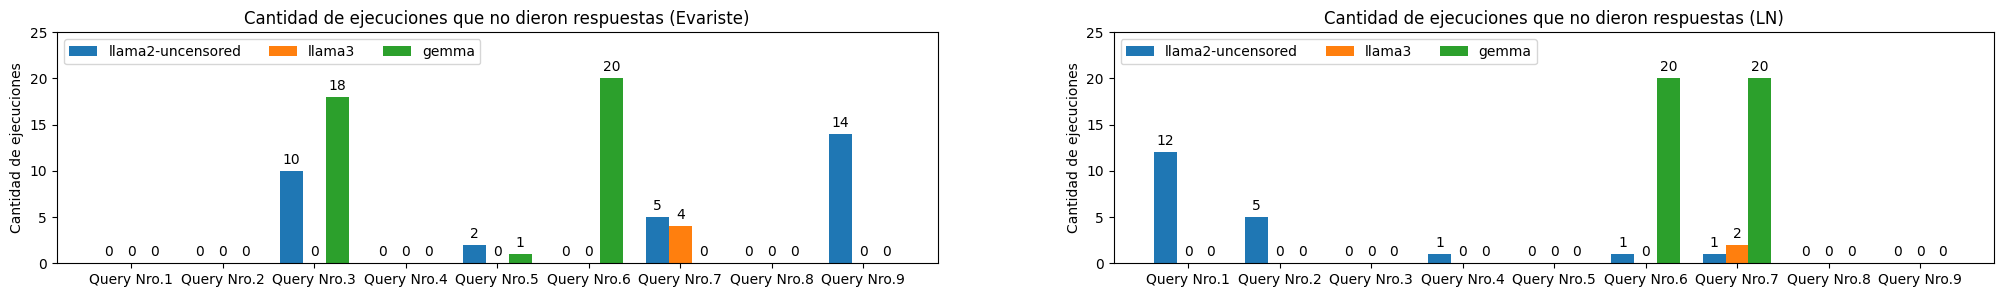

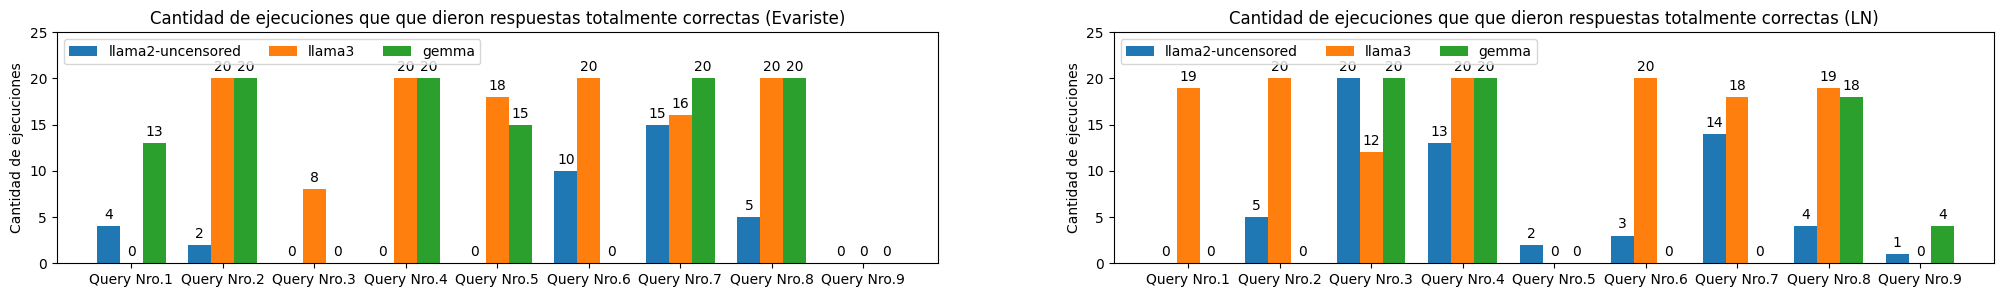

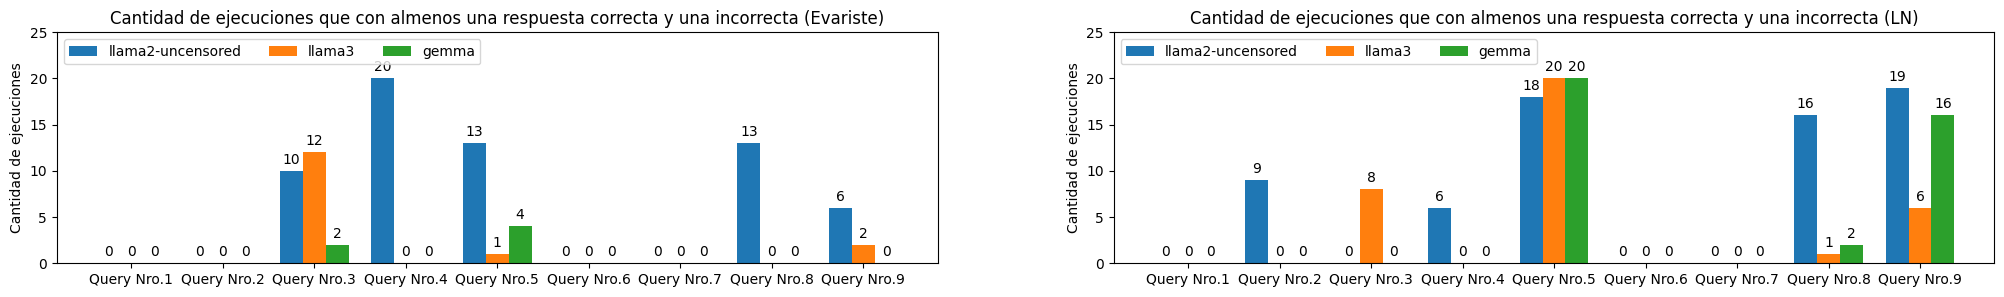

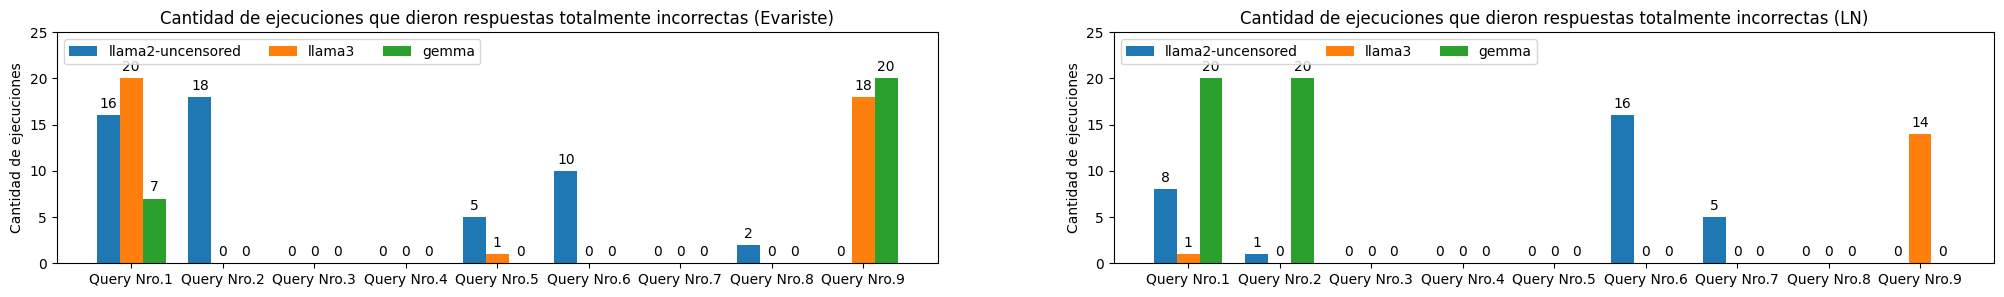

In [17]:
titulos = ['Cantidad de ejecuciones que no dieron respuestas ({version})',
           'Cantidad de ejecuciones que que dieron respuestas totalmente correctas ({version})',
           'Cantidad de ejecuciones que con almenos una respuesta correcta y una incorrecta ({version})',
           'Cantidad de ejecuciones que dieron respuestas totalmente incorrectas ({version})',
           ]

versiones = [('Evariste', 'LN')] * len(titulos)

for datos in zip(calcular_ejecuciones_evariste(), 
                 calcular_ejecuciones_ln(), 
                 titulos, 
                 versiones):
    
    fig, ax = plt.subplots(1, 2, figsize=(25,3))
    diagrama_barra_agrupados(datos[0],
                            [f"Query Nro.{i + 1}" for i in range(len(datos[0]['gemma']))],
                            (10, 5),
                            'Cantidad de ejecuciones',
                            datos[2].format(version=datos[3][0]),
                            [0, 25],
                            fig,
                            ax[0])
    diagrama_barra_agrupados(datos[1],
                            [f"Query Nro.{i + 1}" for i in range(len(datos[1]['gemma']))],
                            (10, 5),
                            'Cantidad de ejecuciones',
                            datos[2].format(version=datos[3][1]),
                            [0, 25],
                            fig,
                            ax[1])

# Imprimir las graficas de barra para los queries y las cantidades de ejecuiciones que dieron precision y recal igual a 0 o mayor; y la cantidad de ejecuciones que no devolvieron nada

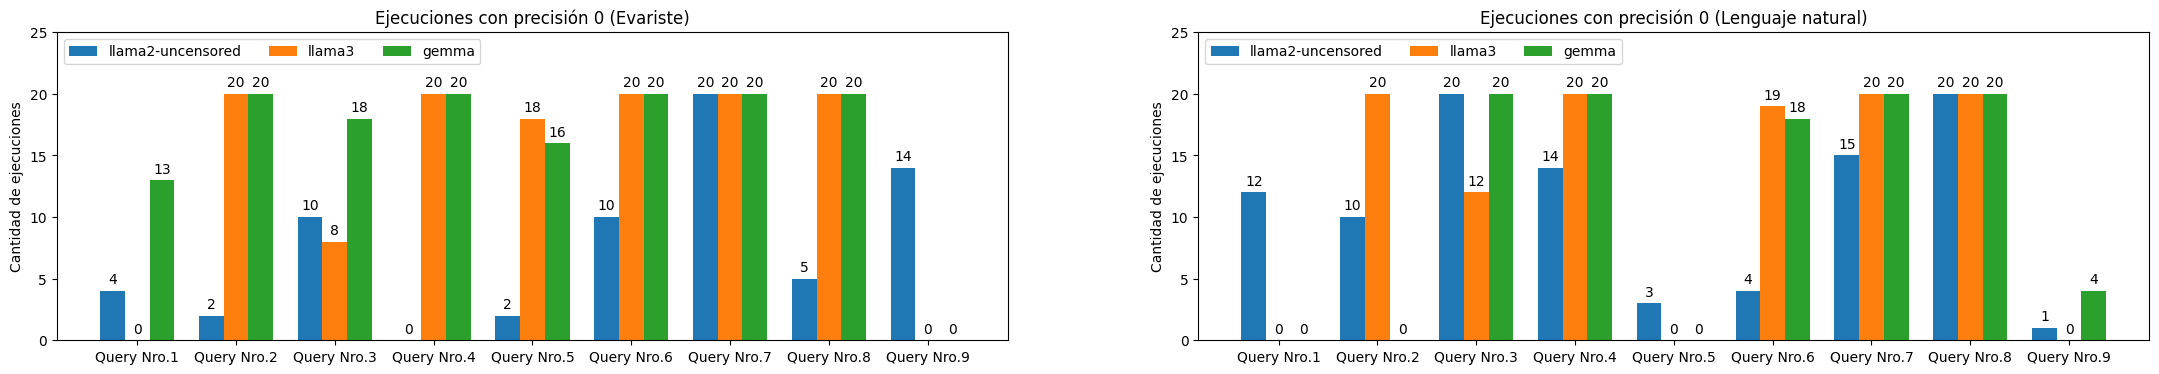

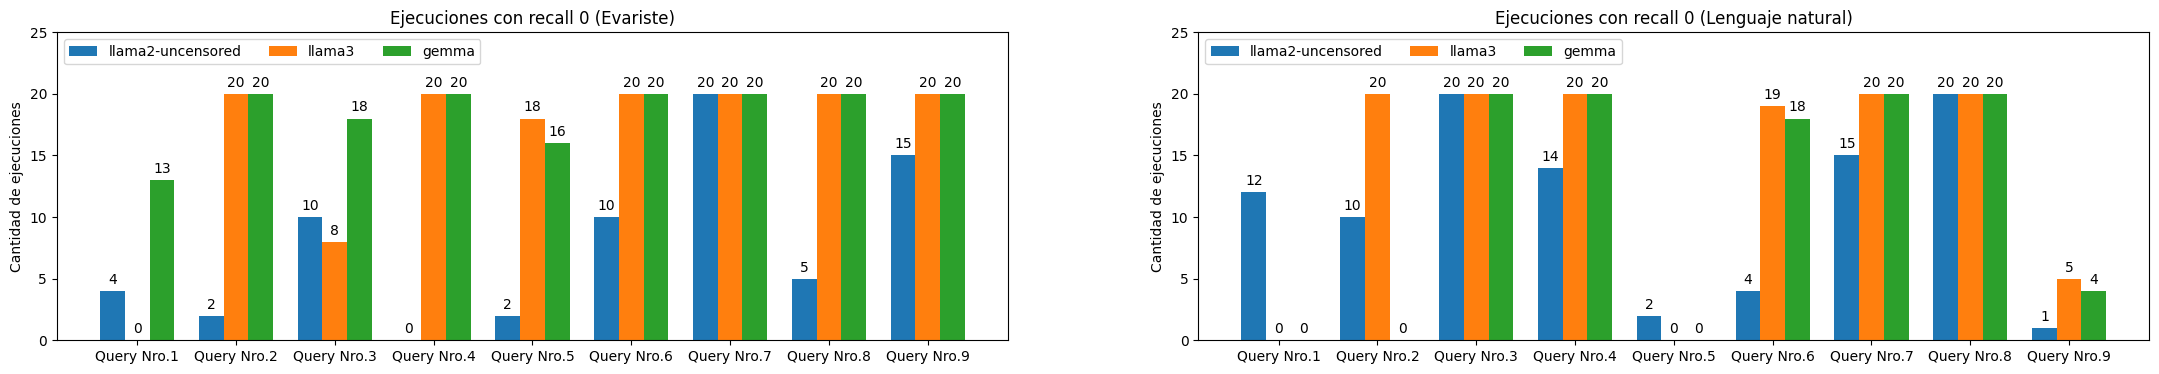

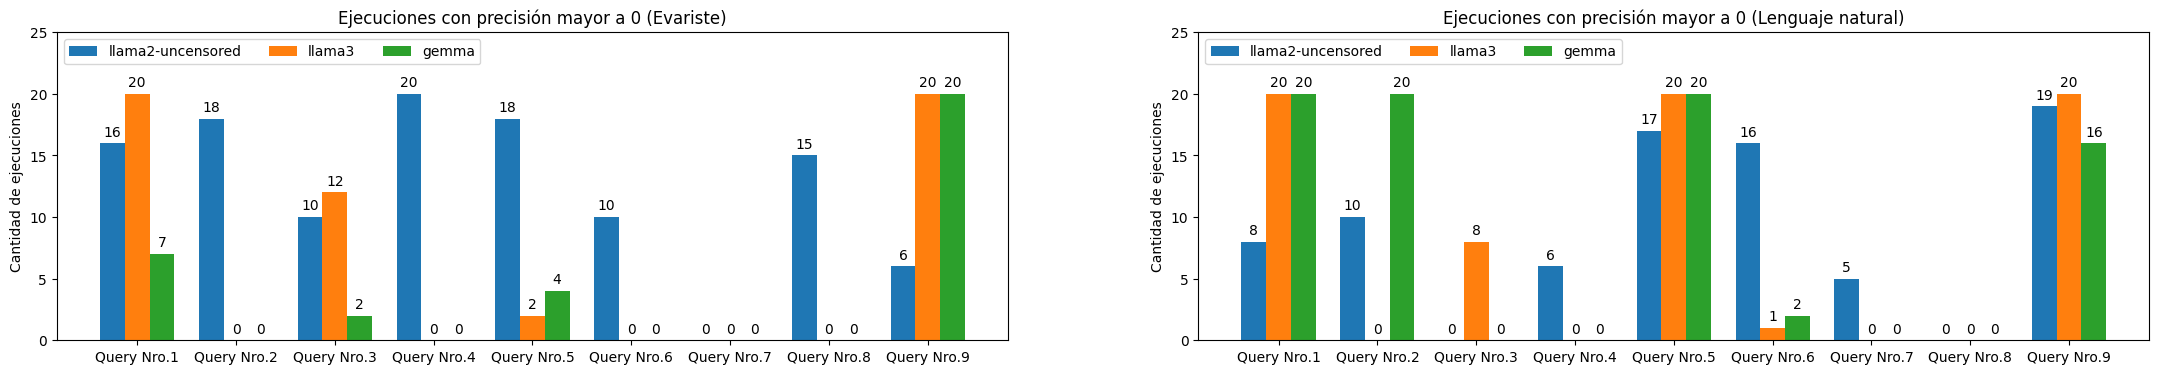

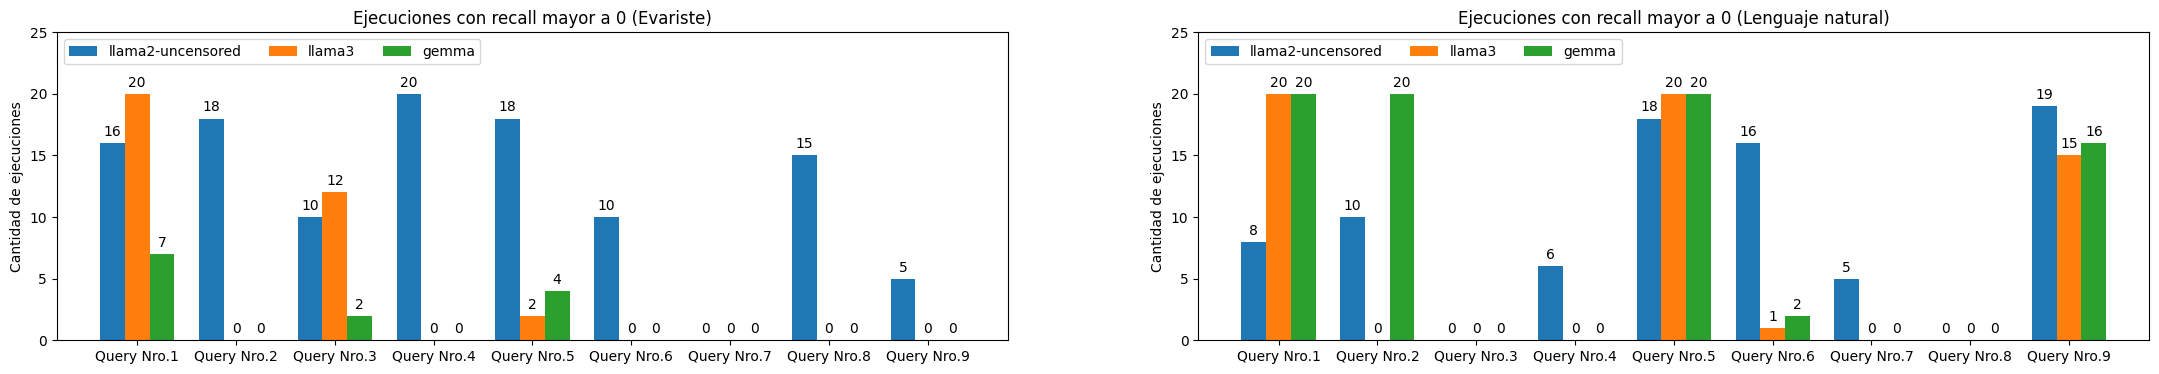

In [81]:
(precision_iguales_cero_queries, 
 precision_distintos_cero_queries, 
 recall_iguales_cero_queries, 
 recall_distintos_cero_queries,
 datos_precision_df_queries,
 datos_recall_df_queries) = calcular_cantidad_precision_recall('resultados/metricas/queries/resumen_queries_chequeo_manual.xlsx',
                                                               ['llama2-uncensored', 'llama3', 'gemma'])

(precision_iguales_cero_ln, 
 precision_distintos_cero_ln, 
 recall_iguales_cero_ln, 
 recall_distintos_cero_ln,
 datos_precision_df_ln,
 datos_recall_df_ln) = calcular_cantidad_precision_recall('resultados/metricas/ln/resumen_ln_chequeo_manual.xlsx', 
                                                          ['llama2-uncensored', 'llama3', 'gemma'])

fig, axs = plt.subplots(1,2, figsize=(27,4))
for datos in zip([precision_iguales_cero_queries, precision_iguales_cero_ln], [datos_precision_df_queries, datos_precision_df_ln], ['Evariste', 'Lenguaje natural'], [0, 1]):
    diagrama_barra_agrupados(datos[0],
                            [f"Query Nro.{i + 1}" for i in range(len(datos[1]['query'].unique()))],
                            (10, 5),
                            'Cantidad de ejecuciones',
                            f'Ejecuciones con precisión 0 ({datos[2]})',
                            [0, 25],
                            fig,
                            axs[datos[3]])

fig, axs = plt.subplots(1,2, figsize=(27,4))
for datos in zip([recall_iguales_cero_queries, recall_iguales_cero_ln], [datos_recall_df_queries, datos_recall_df_ln], ['Evariste', 'Lenguaje natural'], [0, 1]):
    diagrama_barra_agrupados(datos[0],
                            [f"Query Nro.{i + 1}" for i in range(len(datos[1]['query'].unique()))],
                            (10, 5),
                            'Cantidad de ejecuciones',
                            f'Ejecuciones con recall 0 ({datos[2]})',
                            [0, 25],
                            fig,
                            axs[datos[3]])
    
fig, axs = plt.subplots(1,2, figsize=(27,4))
for datos in zip([precision_distintos_cero_queries, precision_distintos_cero_ln], [datos_precision_df_queries, datos_precision_df_ln], ['Evariste', 'Lenguaje natural'], [0, 1]):
    diagrama_barra_agrupados(datos[0],
                            [f"Query Nro.{i + 1}" for i in range(len(datos[1]['query'].unique()))],
                            (10, 5),
                            'Cantidad de ejecuciones',
                            f'Ejecuciones con precisión mayor a 0 ({datos[2]})',
                            [0, 25],
                            fig,
                            axs[datos[3]])


fig, axs = plt.subplots(1,2, figsize=(27,4))
for datos in zip([recall_distintos_cero_queries, recall_distintos_cero_ln], [datos_recall_df_queries, datos_recall_df_ln], ['Evariste', 'Lenguaje natural'], [0, 1]):
    diagrama_barra_agrupados(datos[0],
                            [f"Query Nro.{i + 1}" for i in range(len(datos[1]['query'].unique()))],
                            (10, 5),
                            'Cantidad de ejecuciones',
                            f'Ejecuciones con recall mayor a 0 ({datos[2]})',
                            [0, 25],
                            fig,
                            axs[datos[3]])

In [18]:
for query in datos_precision_df_queries['query'].unique():
    print(query)

SELECT t1.area FROM country as t1 WHERE t1.countryName = "Spain";
SELECT T2.Language FROM country AS T1 JOIN countrylanguage AS T2 ON T1.name = T2.CountryName WHERE T1.HeadOfState = "Felipe VI" AND T2.IsOfficial = "T"
select t3.name from country as t1 join countrylanguage as t2 on t1.name = t2.CountryName join city as t3 on t1.name = t3.CountryName where t2.isofficial = "t" and t2.language = "chinese" and t1.continent = "asia"
SELECT T1.name FROM country as T1 WHERE T1.Government_Form != "Republic" EXCEPT SELECT T1.CountryName FROM countrylanguage as T1 WHERE T1.LANGUAGE = "English"
SELECT T1.name FROM country AS T1 JOIN countrylanguage AS T2 ON T1.name = T2.CountryName WHERE T2.Language = "English" AND T2.IsOfficial = "T" UNION SELECT T1.name FROM country AS T1 JOIN countrylanguage AS T2 ON T1.name = T2.CountryName WHERE T2.Language = "Dutch" AND T2.IsOfficial = "T"
SELECT T1.Name, T1.LifeExpectancy FROM country AS T1 WHERE T1.Continent = "Asia" ORDER BY T1.LifeExpectancy LIMIT 1
SELE

# Calculando diferencias

In [22]:
# interceptamos las respuestas reales contra las predichas
path_archivo_predicciones = 'resultados/ejecucion_preguntas_ln_salida_md/llama3/ejecuciones_preguntas_ln_nro_8.log'
path_archivo_realidad = 'resultados/ejecucion_realidad/ejecucion_realidad_nro_8.log'

respuesta_real = pd.DataFrame()

with open(path_archivo_realidad,'r') as f:
    contenido:str = f.read()
    inicio = contenido.find("INFO: resultado: '''") - len("INFO: resultado: '''") - 1
    fin = contenido.find(" '''\nWARNING: }") - 1
    
    respuesta_real = mdpd.from_md(contenido[inicio : fin])

respuesta_real['Speakers_percentage'] = respuesta_real['Speakers_percentage'].apply(lambda x: float(x))

respuestas_predichas = []
with open(path_archivo_predicciones, 'r') as f:
    contenido:str = f.read()
    
    inicios = [inicio.end () for inicio in re.finditer("INFO: resultado: '''", contenido)]
    finales = [final.start() for final in re.finditer(" '''\nWARNING: }", contenido)]
    ejecuciones = [final.group(1) for final in re.finditer(r"INFO: tiempo: (\d*.\d*),", contenido)]
    for i in range(len(inicios)):
        tabla = mdpd.from_md(contenido[inicios[i] + 1: finales[i]-1])
        while len(tabla.columns) > 2:
            tabla.drop(columns=[tabla.columns[len(tabla.columns) - 1]],inplace=True)
            
        tabla.columns = ['T1.Country_name', 'T1.Speakers_percentage']
        if len(tabla) != 0:
            tabla['T1.Speakers_percentage'] = tabla['T1.Speakers_percentage'].apply(lambda x: float(x.replace("%", "").replace("<", "").replace("N/A", "0").replace("Unknow", "0").replace("0n", "0")))
            
        respuestas_predichas.append(tabla)

precision = []
recall = []
for prediccion, tiempo in zip(respuestas_predichas, ejecuciones):
    
    resumen = {}
    resumen['Cantidad de respuestas esperadas'] = len(respuesta_real)
    resumen['Cantidad de respuesta predichas'] = len(prediccion) 
    resumen['Tiempo de ejecución'] = tiempo
    
    resultado = prediccion.merge(respuesta_real, left_on=['T1.Country_name'], right_on=['Country_name'])
    resultado = resultado[abs(resultado['Speakers_percentage'] - resultado['T1.Speakers_percentage'])<= 10]
    resultado.drop_duplicates(subset=['T1.Country_name'], keep='first', inplace=True, ignore_index=True)
    
    if  resumen['Cantidad de respuesta predichas'] == 0:
        precision.append(0)
    else:
        precision.append(round(len(resultado) / resumen['Cantidad de respuesta predichas'],2))
    
    recall.append(round(len(resultado)/ resumen['Cantidad de respuestas esperadas'], 2))

print(precision) 
print(recall)

   

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.61, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Promedio del recall y la precisión

In [66]:
def calcular_promedio_precision_recall(direccion_archivo_resumen: str, ):
    excel_file = pd.ExcelFile(direccion_archivo_resumen)
    queries = pd.read_excel('./ignorar/queries_ejecutar_modificados.xlsx')['query'].to_list()
    
    datos_precision_df = excel_file.parse('precision')
    datos_recall_df = excel_file.parse('recall')
    modelos = ['llama2-uncensored', 'llama3', 'gemma']
    
    datos_precision_promedio = []
    datos_recall_promedio = []

    for modelo in modelos:
        for query in datos_precision_df['query'].unique():
            datos_precision_tiempo = datos_precision_df.loc[(datos_precision_df['modelo'] == modelo) & (datos_precision_df['query'] == query) & (datos_precision_df['precision'] != 0)]
            datos_recall_tiempo = datos_recall_df.loc[(datos_recall_df['modelo'] == modelo) & (datos_recall_df['query'] == query) & (datos_recall_df['recall'] != 0)]
                    
            datos_precision_promedio.append([query, queries.index(query),modelo, datos_precision_tiempo['precision'].mean(), datos_precision_tiempo['tiempo'].mean()])
            datos_recall_promedio.append([query, queries.index(query),modelo, datos_recall_tiempo['recall'].mean(), datos_recall_tiempo['tiempo'].mean()])
            

    datos_precision_promedio_df = pd.DataFrame(datos_precision_promedio, columns=['query', 'Nro', 'modelo', 'precision', 'tiempo'])
    datos_recall_promedio_df = pd.DataFrame(datos_recall_promedio, columns=['query', 'Nro', 'modelo', 'recall', 'tiempo'])
    
    return datos_precision_promedio_df.dropna(), datos_recall_promedio_df.dropna()

In [67]:
def construir_barras_promedio(df, columan_modelo, columna_datos, columna_group_by, modelos_disponibles):
    barras = {}
    for posicion, tabla in (df.groupby(columna_group_by)):
        modelos_grupo = tabla[columan_modelo].to_list()
        valores_grupo = tabla[columna_datos].to_list()
        
        # print(f"posicion {posicion}, {valores_grupo} -> {len(valores_grupo)}, {modelos_grupo} -> {len(modelos_grupo)}, {modelos_disponibles} -> {len(modelos_disponibles)}")
        if len(modelos_grupo) < len(modelos_disponibles):
            valores_grupo += [0 for _ in range(len(modelos_disponibles) - len(modelos_grupo))]
            modelos_grupo += [modelo for modelo in modelos_disponibles if modelo not in modelos_grupo]
        
            
        barras[posicion] = {columan_modelo: modelos_grupo,
                            columna_datos: valores_grupo }
    
    return barras

In [68]:
from matplotlib.patches import Patch

def grafica_barra_agrupada(datos, 
                           titulo,
                           ylabel,
                           xticks,
                           colores_modelos, 
                           nombre_valores, 
                           fig, 
                           ax, 
                           nombre_modelos = "modelo",
                           ancho_barra = 0.25, 
                           xlabel = "",
                           ):

    x = np.arange(len(datos.keys()))
    
    width = ancho_barra  # the width of the bars

    # fig, ax = plt.subplots(figsize=(13,5))

    # colores_modelos = {'llama2-uncensored': 'tab:blue',
    #                 'llama3': 'tab:orange',
    #                 'gemma': 'tab:green'}

    contador = 0
    for _, values in datos.items():
        if values != [0] * len(values[nombre_valores]):
            offset = np.array([-width, 0, width])
            print()
            rects = ax.bar(offset + contador + width, values[nombre_valores], width, label=f"{offset + contador}", color=[colores_modelos[modelo] for modelo in values[nombre_modelos]])
            contador += 1

    # ax.set_ylabel('promedio')
    # ax.set_title('Promedio de la Precisión')
    # ax.set_xticks(x + width, [f"Query Nro.{i +1}" for i in barras.keys()])
    
    ax.set_ylabel(ylabel)
    ax.set_title(titulo)
    ax.set_xticks(x + width, xticks)

    legend_elements = [Patch(facecolor=colores_modelos[modelo],label=modelo) for modelo in colores_modelos]

    ax.legend(handles= legend_elements, ncols=1)

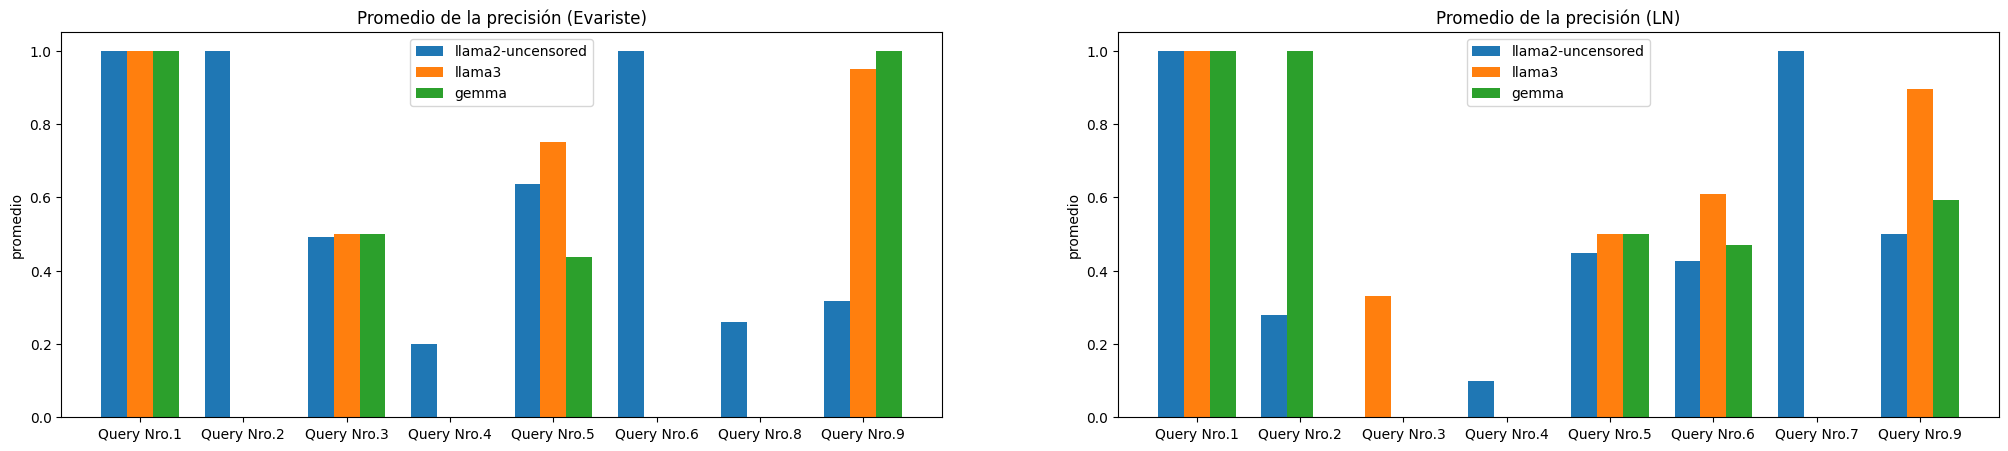

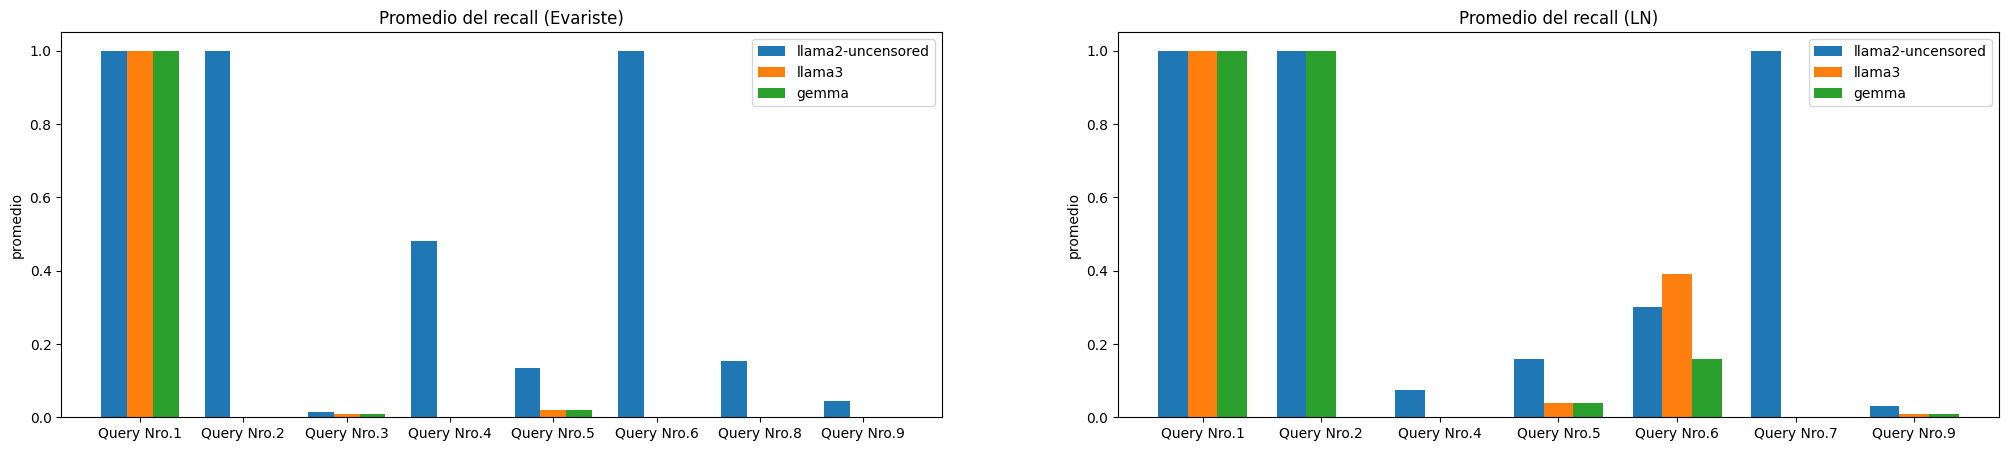

{0: {'modelo': ['llama2-uncensored', 'llama3', 'gemma'], 'recall': [1.0, 1.0, 1.0]}, 1: {'modelo': ['llama2-uncensored', 'gemma', 'llama3'], 'recall': [1.0, 1.0, 0]}, 3: {'modelo': ['llama2-uncensored', 'llama3', 'gemma'], 'recall': [0.075, 0, 0]}, 4: {'modelo': ['llama2-uncensored', 'llama3', 'gemma'], 'recall': [0.16, 0.04000000000000001, 0.04000000000000001]}, 5: {'modelo': ['llama2-uncensored', 'llama3', 'gemma'], 'recall': [0.3, 0.39, 0.16]}, 6: {'modelo': ['llama2-uncensored', 'llama3', 'gemma'], 'recall': [1.0, 0, 0]}, 8: {'modelo': ['llama2-uncensored', 'llama3', 'gemma'], 'recall': [0.03157894736842106, 0.01, 0.01]}}


In [92]:
df_precision_evariste, df_recall_evariste = calcular_promedio_precision_recall('resultados/metricas/queries/resumen_queries_chequeo_manual.xlsx')
df_precision_ln, df_recall_ln = calcular_promedio_precision_recall('resultados/metricas/ln/resumen_ln_chequeo_manual.xlsx')

modelos_disponibles = ['llama2-uncensored', 'llama3', 'gemma']
colores_modelos = {'llama2-uncensored': 'tab:blue',
                'llama3': 'tab:orange',
                'gemma': 'tab:green'}

fig, axs = plt.subplots(1, 2, figsize = (25,5))
barras = construir_barras_promedio(df_precision_evariste, "modelo", "precision", "Nro", modelos_disponibles)
grafica_barra_agrupada(barras, 
                       "Promedio de la precisión (Evariste)", 
                       "promedio", 
                       [f"Query Nro.{i +1}" for i in barras.keys()], 
                       colores_modelos, 
                       'precision',
                       fig,
                       axs[0],
                       "modelo")

barras = construir_barras_promedio(df_precision_ln, "modelo", "precision", "Nro", modelos_disponibles)
grafica_barra_agrupada(barras, 
                       'Promedio de la precisión (LN)', 
                       'promedio', 
                       [f"Query Nro.{i +1}" for i in barras.keys()], 
                       colores_modelos, 
                       'precision',
                       fig,
                       axs[1],
                       'modelo')

plt.show()

fig, axs = plt.subplots(1, 2, figsize = (25,5))
barras = construir_barras_promedio(df_recall_evariste, "modelo", "recall", "Nro", modelos_disponibles)
grafica_barra_agrupada(barras, 
                       "Promedio del recall (Evariste)", 
                       "promedio", 
                       [f"Query Nro.{i +1}" for i in barras.keys()], 
                       colores_modelos, 
                       'recall',
                       fig,
                       axs[0],
                       "modelo")

barras = construir_barras_promedio(df_recall_ln, "modelo", "recall", "Nro", modelos_disponibles)
grafica_barra_agrupada(barras, 
                       'Promedio del recall (LN)', 
                       'promedio', 
                       [f"Query Nro.{i +1}" for i in barras.keys()], 
                       colores_modelos, 
                       'recall',
                       fig,
                       axs[1],
                       'modelo')

plt.show()


print(barras)

# Graficos finales

## Calculo de los datos

### Creamos un resumen de las ejecuciones

In [56]:
def obtener_respuesta_real_predicciones(archivo_realidad: str, archivo_predicciones:str):
    """
    Dado el log de la respuesta que debe dar la ejecuciio y el log de las predicciones
    que hizo el modelo, obtiene estas respuestas y las devuelve
    """
    respuesta_real = pd.DataFrame()
    
    with open(archivo_realidad,'r') as f:
        contenido:str = f.read()
        inicio = contenido.find("INFO: resultado: '''") - len("INFO: resultado: '''") - 1
        fin = contenido.find(" '''\nWARNING: }") - 1
        
        respuesta_real = mdpd.from_md(contenido[inicio : fin])
    
    respuestas_predichas = []
    with open(archivo_predicciones, 'r') as f:
        contenido:str = f.read()
        
        inicios = [inicio.end () for inicio in re.finditer("INFO: resultado: '''", contenido)]
        finales = [final.start() for final in re.finditer(" '''\nWARNING: }", contenido)]
        for i in range(len(inicios)):
            respuestas_predichas.append(mdpd.from_md(contenido[inicios[i] + 1: finales[i]-1]))
    
    return respuesta_real, respuestas_predichas

In [57]:
def clasificar_ejecuciones(archivo_comparacion: str, 
                           columna_archivo_real: str, 
                           columna_archivo_predicciones: str,
                           columnas_comparacion_archivo_real: str,
                           columnas_comparacion_archivo_predicciones: str,
                           carpeta_ejecuciones: str,
                           carpeta_realidad: str,
                           modelos: list[str],
                           datos_recuentos,
                           join_especiales
                           ):
    """
     Devuelve un diccionario donde la llave es un modelo 
     y cada valor es una lista con el resultado de todas
     las queries a comparar
    """
    datos_comparacion = pd.read_excel(archivo_comparacion)
    datos_comparacion[columnas_comparacion_archivo_real] = datos_comparacion[columnas_comparacion_archivo_real].apply(ast.literal_eval)
    datos_comparacion[columnas_comparacion_archivo_predicciones] = datos_comparacion[columnas_comparacion_archivo_predicciones].apply(ast.literal_eval)

    cantidad_no_respuesta = {}
    cantidad_respuestas_incorrectas = {}
    cantidad_respuestas_correctas_incorrectas = {}
    cantidad_respuestas_correctas = {}

    for modelo in modelos:
        
        cantidad_no_respuesta[modelo] = [0] * len(datos_comparacion)
        cantidad_respuestas_incorrectas[modelo] = [0] * len(datos_comparacion)
        cantidad_respuestas_correctas_incorrectas[modelo] = [0] * len(datos_comparacion)
        cantidad_respuestas_correctas[modelo] = [0] * len(datos_comparacion)
        
        for i, datos in datos_comparacion.iterrows():
            respuesta_real, respuestas_predichas = obtener_respuesta_real_predicciones(os.path.join(carpeta_realidad, datos[columna_archivo_real]), 
                                                                                       os.path.join(carpeta_ejecuciones, modelo, datos[columna_archivo_predicciones]))
            
            for j, respuesta in enumerate(respuestas_predichas):
                if len(respuesta) == 0:
                    cantidad_no_respuesta[modelo][i] += 1
                    continue
                
                respuesta['posicion'] = respuesta.index
                
                if join_especiales.get(i) == None: 
                    join = respuesta.merge(respuesta_real, right_on = datos[columnas_comparacion_archivo_real], left_on = datos[columnas_comparacion_archivo_predicciones])
                    join.drop_duplicates(subset=datos[columnas_comparacion_archivo_predicciones], keep='first', inplace=True)
                else:
                   join = join_especiales[i](respuesta, respuesta_real, datos, columnas_comparacion_archivo_predicciones, columnas_comparacion_archivo_real)                
                
                difference = respuesta.drop(join.drop_duplicates(subset=['posicion'], keep='first')['posicion'])
                if len(join) == 0:
                    cantidad_respuestas_incorrectas[modelo][i] += 1
                    continue
                
                if len(join) > 0 and len(difference) > 0:
                    cantidad_respuestas_correctas_incorrectas[modelo][i] += 1
                    continue
                
                if len(join) > 0 and len(difference) == 0:
                    cantidad_respuestas_correctas[modelo][i] += 1

    for i, recuentos in datos_recuentos:
        for modelo in recuentos:
            for cantidad in recuentos[modelo]:
                match cantidad:
                    case 'cantidad_no_respuesta': cantidad_no_respuesta[modelo][i] = recuentos[modelo][cantidad]
                    case 'cantidad_respuestas_incorrectas': cantidad_respuestas_incorrectas[modelo][i] = recuentos[modelo][cantidad]
                    case 'cantidad_respuestas_correctas_incorrectas': cantidad_respuestas_correctas_incorrectas[modelo][i] = recuentos[modelo][cantidad]
                    case 'cantidad_respuestas_correctas': cantidad_respuestas_correctas[modelo][i] = recuentos[modelo][cantidad]
    
    return cantidad_no_respuesta, cantidad_respuestas_incorrectas, cantidad_respuestas_correctas_incorrectas, cantidad_respuestas_correctas

In [58]:
def calcular_metricas(archivo_comparacion: str, 
                      columna_archivo_real: str, 
                      columna_archivo_predicciones: str,
                      columnas_comparacion_archivo_real: str,
                      columnas_comparacion_archivo_predicciones: str,
                      carpeta_ejecuciones: str,
                      carpeta_realidad: str,
                      modelos: list[str],
                      datos_recuentos,
                      join_especiales
                    ):
    """
     Devuelve un diccionario donde la llave es un modelo 
     y cada valor es una lista con el resultado de todas
     las queries a comparar
    """
    datos_comparacion = pd.read_excel(archivo_comparacion)
    datos_comparacion[columnas_comparacion_archivo_real] = datos_comparacion[columnas_comparacion_archivo_real].apply(ast.literal_eval)
    datos_comparacion[columnas_comparacion_archivo_predicciones] = datos_comparacion[columnas_comparacion_archivo_predicciones].apply(ast.literal_eval)

    precision = {}
    recall = {}
    f1 = {}
    
    for modelo in modelos:
        
        for i, datos in datos_comparacion.iterrows():
            respuesta_real, respuestas_predichas = obtener_respuesta_real_predicciones(os.path.join(carpeta_realidad, datos[columna_archivo_real]), 
                                                                                       os.path.join(carpeta_ejecuciones, modelo, datos[columna_archivo_predicciones]))
            precision_query = []
            recall_query = []
            f1_query = []
            for j, respuesta in enumerate(respuestas_predichas):
                if len(respuesta) == 0:
                    precision_query.append(0)
                    recall_query.append(0)
                    f1_query.append(0)
                    continue
                                
                if join_especiales.get(i) == None: 
                    join = respuesta.merge(respuesta_real, right_on = datos[columnas_comparacion_archivo_real], left_on = datos[columnas_comparacion_archivo_predicciones])
                    join.drop_duplicates(subset=datos[columnas_comparacion_archivo_predicciones], keep='first', inplace=True)
                else:
                   join = join_especiales[i](respuesta, respuesta_real, datos, columnas_comparacion_archivo_predicciones, columnas_comparacion_archivo_real)                
                
                precision_query.append(len(join)/len(respuesta))
                recall_query.append(len(join)/ len(respuesta_real))
                
                if recall_query[-1] == 0 or recall_query[-1]== 0:
                    f1_query.append(0)
                else: 
                    f1_query.append((2 * precision_query[-1] * recall_query[-1])/(precision_query[-1] + recall_query[-1]))
            
            for diccionario, fila in zip([precision, recall, f1], [precision_query, recall_query, f1_query]):
            
                if diccionario.get(modelo) == None:
                    diccionario[modelo] = []
                            
                diccionario[modelo].append(fila)

    for i, recuentos in datos_recuentos:
        for modelo in recuentos:
            if recuentos.get(modelo) == None:
                continue
            
            for metrica in recuentos[modelo]:
                match metrica:
                    case 'precision': precision[modelo][i] = recuentos[modelo][metrica]
                    case 'recall': recall[modelo][i] = recuentos[modelo][metrica]
                
                nuevo_f1 = []

                for precision_ejecucion, recall_ejecucion in zip(precision[modelo][i], recall[modelo][i]):
                    if precision_ejecucion == 0 or recall_ejecucion == 0:
                        nuevo_f1.append(0)
                    else:
                        nuevo_f1.append((2 * precision_ejecucion * recall_ejecucion)/(precision_ejecucion + recall_ejecucion))
                
                f1[modelo][i] = nuevo_f1
    return precision, recall, f1

In [59]:
def obtener_tiempos(archivo_comparacion: str,
                    columna_archivo_predicciones: str,
                    carpeta_ejecuciones: str,
                    modelos: list[str],
                    ):
    datos_comparacion = pd.read_excel(archivo_comparacion)
    
    tiempos = {}
   
    for modelo in modelos:        
        for i, datos in datos_comparacion.iterrows():
            with open(os.path.join(carpeta_ejecuciones, modelo, datos[columna_archivo_predicciones]), 'r') as f:
                contenido:str = f.read()
                tiempos_ejecuciones = [float(final.group(1)) for final in re.finditer(r"INFO: tiempo: (\d*.\d*),", contenido)]
        
            if tiempos.get(modelo) == None:
                tiempos[modelo] = []
            
            tiempos[modelo].append(tiempos_ejecuciones)
    
    return tiempos

In [60]:
def obtener_ejecuciones(archivo_comparacion: str,
                        columna_archivo_predicciones: str,
                        carpeta_ejecuciones: str,
                        modelos: list[str],
                        ):
    datos_comparacion = pd.read_excel(archivo_comparacion)
    
    ejecuciones = {}
   
    for modelo in modelos:        
        for i, datos in datos_comparacion.iterrows():
            with open(os.path.join(carpeta_ejecuciones, modelo, datos[columna_archivo_predicciones]), 'r') as f:
                contenido:str = f.read()
                cantidad_ejecuciones = [float(final.group(1)) for final in re.finditer(r"INFO: cantidad_peticiones_LLM: (\d*),", contenido)]
        
            if ejecuciones.get(modelo) == None:
                ejecuciones[modelo] = []
            
            ejecuciones[modelo].append(cantidad_ejecuciones)
    
    return ejecuciones

In [61]:
def resumen_evariste():
    # recuentos manuales 
    recuento_manual_query_1 = (0, {
                                'gemma': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 13, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 7, 
                                            
                                },
                                'llama2-uncensored': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 4, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 16, 
                                            
                                },
                                'llama3': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 20, 
                                },
    })

    recuento_manual_query_6 = (5, {
                                'gemma': {
                                            'cantidad_no_respuesta': 20, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                            
                                },
                                'llama2-uncensored': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 10, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 10, 
                                            
                                },
                                'llama3': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 20, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                },
    })

    datos_recuentos = [recuento_manual_query_1, recuento_manual_query_6]


    # precision, recall y f1 manuales
    pr_manual_query_1 = (0, {
                            'gemma': {
                                    'precision': [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
                                    'recall': [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
                            },
                            'llama2-uncensored':{
                                    'precision': [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
                                    'recall': [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
                            },
                            'llama3': {
                                    'precision': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                                    'recall': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                            },
    })
    
    pr_manual_query_6 = (5, {
                            'llama2-uncensored':{
                                    'precision': [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
                                    'recall': [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
                            },
    })

    datos_pr_recuento = [pr_manual_query_1, pr_manual_query_6]

    def join_query_8(respuesta, respuesta_real, datos, columnas_comparacion_archivo_predicciones, columnas_comparacion_archivo_real):
        join = respuesta.merge(respuesta_real, left_on=['T1.Country_name'], right_on=['Country_name'])
        join['T1.Speakers_percentage'] = join['T1.Speakers_percentage'].apply(lambda x: float(x.replace("%", "").replace("<", "").replace("N/A", "0").replace("Unknow", "0").replace("0n", "0")))
        join['Speakers_percentage'] = join['Speakers_percentage'].apply(lambda x: float(x))
        join = join[abs(join['Speakers_percentage'] - join['T1.Speakers_percentage'])<= 10]

        join.drop_duplicates(subset=datos[columnas_comparacion_archivo_predicciones], keep='first', inplace=True)
        
        return join

    resumen = list(clasificar_ejecuciones('ignorar/comparar_resultados_mk2.xlsx', 
                                          'archivo realidad', 
                                          'archivo evariste',
                                          'columnas realidad', 
                                          'columnas ejecuciones',
                                          'resultados/ejecucion_queries_salida_md',
                                          'resultados/ejecucion_realidad',
                                          ['llama2-uncensored', 'llama3', 'gemma'],
                                          datos_recuentos,
                                          {7:join_query_8} ))
    resumen.append(obtener_tiempos('ignorar/comparar_resultados_mk2.xlsx',
                                    'archivo evariste',
                                    'resultados/ejecucion_queries_salida_md',
                                    ['llama2-uncensored', 'llama3', 'gemma']))
    
    resumen += list(calcular_metricas('ignorar/comparar_resultados_mk2.xlsx', 
                                          'archivo realidad', 
                                          'archivo evariste',
                                          'columnas realidad', 
                                          'columnas ejecuciones',
                                          'resultados/ejecucion_queries_salida_md',
                                          'resultados/ejecucion_realidad',
                                          ['llama2-uncensored', 'llama3', 'gemma'],
                                          datos_pr_recuento,
                                          {7:join_query_8} ))

    return tuple(resumen)

In [62]:
def resumen_ln():
    # recuentos manuales 
    recuento_manual_query_1 = (0, {
                                'gemma': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 20, 
                                            
                                },
                                'llama2-uncensored': {
                                            'cantidad_no_respuesta': 12, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 8, 
                                            
                                },
                                'llama3': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 19, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 1, 
                                },
    })

    recuento_manual_query_6 = (5, {
                                'gemma': {
                                            'cantidad_no_respuesta': 20, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                            
                                },
                                'llama2-uncensored': {
                                            'cantidad_no_respuesta': 1, 
                                            'cantidad_respuestas_incorrectas': 3, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 16, 
                                            
                                },
                                'llama3': {
                                            'cantidad_no_respuesta': 0, 
                                            'cantidad_respuestas_incorrectas': 20, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                },
    })

    recuento_manual_query_7 = (6, {
                                'gemma': {
                                            'cantidad_no_respuesta': 20, 
                                            'cantidad_respuestas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                            
                                },
                                'llama2-uncensored': {
                                            'cantidad_no_respuesta': 1, 
                                            'cantidad_respuestas_incorrectas': 14, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 5, 
                                            
                                },
                                'llama3': {
                                            'cantidad_no_respuesta': 2, 
                                            'cantidad_respuestas_incorrectas': 18, 
                                            'cantidad_respuestas_correctas_incorrectas': 0, 
                                            'cantidad_respuestas_correctas': 0, 
                                },
    })

    datos_recuentos = [recuento_manual_query_1, recuento_manual_query_6, recuento_manual_query_7]

    # precision, recall y f1 manuales
    pr_manual_query_1 = (0, {
                            'gemma': {
                                    'precision': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ],
                                    'recall': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                            },
                            'llama2-uncensored':{
                                    'precision': [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, ],
                                    'recall': [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, ],
                            },
                            'llama3': {
                                    'precision': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ],
                                    'recall': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ],
                            },
    })

    pr_manual_query_6 = (5, {
                            'gemma': {
                                    'precision': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],
                                    'recall': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
                            },
                            'llama2-uncensored':{
                                    'precision': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ],
                                    'recall': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ],
                            },
    })
    
    pr_manual_query_7 = (6, {
                            'llama2-uncensored':{
                                    'precision': [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0 ],
                                    'recall': [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
                            },
    })

    datos_pr_recuento = [pr_manual_query_1, pr_manual_query_6, pr_manual_query_7]

    def join_query_8(respuesta, respuesta_real, datos, columnas_comparacion_archivo_predicciones, columnas_comparacion_archivo_real):
        if 'posicion' in respuesta.columns:
               respuesta.drop("posicion", axis=1, inplace=True)
        
        while len(respuesta.columns) > len(respuesta_real.columns):
                    respuesta.drop(columns=[respuesta.columns[len(respuesta.columns) - 1]], inplace=True)

        respuesta.columns = [f"{columna}_r" for columna in respuesta_real.columns]
        respuesta['posicion'] = respuesta.index

        join = respuesta.merge(respuesta_real, left_on=['Country_name_r'], right_on=['Country_name'])
        join['Speakers_percentage_r'] = join['Speakers_percentage_r'].apply(lambda x: float(x.replace("%", "").replace("<", "").replace("N/A", "0").replace("Unknow", "0").replace("0n", "0")))
        join['Speakers_percentage'] = join['Speakers_percentage'].apply(lambda x: float(x))
        join = join[abs(join['Speakers_percentage'] - join['Speakers_percentage_r'])<= 10]

        join.drop_duplicates(subset=[f"{columna}_r" for columna in respuesta_real.columns], keep='first', inplace=True)
        
        return join

    def join_para_ln(respuesta, respuesta_real, datos, columnas_comparacion_archivo_predicciones, columnas_comparacion_archivo_real):
        while len(respuesta.columns) > len(respuesta_real.columns):
                    respuesta.drop(columns=[respuesta.columns[len(respuesta.columns) - 1]], inplace=True)

        if len(respuesta) != 0 and not respuesta.empty:
                respuesta.columns = [f"{columna}_r" for columna in respuesta_real.columns]
                respuesta['posicion'] = respuesta.index

                join = respuesta.merge(respuesta_real, right_on = datos[columnas_comparacion_archivo_real], left_on = [f"{columna}_r" for columna in respuesta_real.columns])
                join.drop_duplicates(subset=[f"{columna}_r" for columna in respuesta_real.columns], keep='first', inplace=True)
        else:
                join = pd.DataFrame([], columns=['posicion'])
        return join

    joins_especiales = {i: join_para_ln if i not in [7] else join_query_8 for i in range(10)}

    resumen = list(clasificar_ejecuciones('ignorar/comparar_resultados_mk2.xlsx', 
                                          'archivo realidad', 
                                          'archivo ln',
                                          'columnas realidad', 
                                          'columnas ejecuciones',
                                          'resultados/ejecucion_preguntas_ln_salida_md',
                                          'resultados/ejecucion_realidad',
                                          ['llama2-uncensored', 'llama3', 'gemma'],
                                          datos_recuentos,
                                          joins_especiales ))
    
    resumen.append(obtener_tiempos('ignorar/comparar_resultados_mk2.xlsx',
                                    'archivo ln',
                                    'resultados/ejecucion_preguntas_ln_salida_md',
                                    ['llama2-uncensored', 'llama3', 'gemma']))
    
    resumen += list(calcular_metricas('ignorar/comparar_resultados_mk2.xlsx', 
                                          'archivo realidad', 
                                          'archivo ln',
                                          'columnas realidad', 
                                          'columnas ejecuciones',
                                          'resultados/ejecucion_preguntas_ln_salida_md',
                                          'resultados/ejecucion_realidad',
                                          ['llama2-uncensored', 'llama3', 'gemma'],
                                          datos_pr_recuento,
                                          joins_especiales ))

    return tuple(resumen)

In [63]:
def resumen_galois():

    resumen = list(clasificar_ejecuciones('ignorar/comparar_resultados_mk2.xlsx', 
                                          'archivo realidad', 
                                          'archivo galois',
                                          'columnas realidad', 
                                          'columnas ejecuciones',
                                          'resultados/ejecucion_queries_galois_salida_md',
                                          'resultados/ejecucion_realidad',
                                          ['llama2-uncensored', 'llama3', 'gemma'],
                                          [],
                                          {}))
    
    resumen.append(obtener_tiempos('ignorar/comparar_resultados_mk2.xlsx',
                                    'archivo galois',
                                    'resultados/ejecucion_queries_galois_salida_md',
                                    ['llama2-uncensored', 'llama3', 'gemma']))
    
    resumen += list(calcular_metricas('ignorar/comparar_resultados_mk2.xlsx', 
                                          'archivo realidad', 
                                          'archivo galois',
                                          'columnas realidad', 
                                          'columnas ejecuciones',
                                          'resultados/ejecucion_queries_galois_salida_md',
                                          'resultados/ejecucion_realidad',
                                          ['llama2-uncensored', 'llama3', 'gemma'],
                                          [],
                                          {} ))
    resumen.append(obtener_ejecuciones('ignorar/comparar_resultados_mk2.xlsx',
                                    'archivo galois',
                                    'resultados/ejecucion_queries_galois_salida_md',
                                    ['llama2-uncensored', 'llama3', 'gemma']))

    return tuple(resumen)

### Creamos archivo con los detalles de cada ejecucion

In [64]:
nr, ri, rci, rc, ejecuciones, precision, recall, f1 = resumen_evariste()

carpeta_resultado = "./resultados/metricas/queries" 

queries = pd.read_excel('ignorar/comparar_resultados_mk2.xlsx')['query']

modelos = ['llama2-uncensored', 'llama3', 'gemma']

datos_prfte = []
datos_promedios_prft = []

for modelo in modelos: # Modelo
    for i in range(len(precision[modelo])): # Query
        for j in range(len(precision[modelo][i])): # Ejecucion
            
            
            datos_prfte.append([
                                queries[i], 
                                modelo, 
                                j+1, 
                                precision[modelo][i][j],
                                recall[modelo][i][j],
                                f1[modelo][i][j],
                                ejecuciones[modelo][i][j]
                            ])
            
        cantidad_precisiones_no_0 = sum([1 for p in precision[modelo][i] if p != 0])
        cantidad_recalls_no_0 = sum([1 for r in recall[modelo][i] if r != 0])
        cantidad_f1s_no_0 = sum([1 for f in f1[modelo][i] if f != 0])

        datos_promedios_prft.append([
                                      queries[i], 
                                      modelo,
                                      (sum(precision[modelo][i])/cantidad_precisiones_no_0) if cantidad_precisiones_no_0 != 0 else 0,
                                      (sum(recall[modelo][i])/cantidad_recalls_no_0) if cantidad_recalls_no_0 != 0 else 0,
                                      (sum(f1[modelo][i]) /cantidad_f1s_no_0) if cantidad_f1s_no_0 != 0 else 0,
                                      sum(ejecuciones[modelo][i])/ len(ejecuciones[modelo][i])
                                    ])

datos_cantidades = []
for modelo in modelos: # Modelo
    for i in range(len(nr[modelo])): # Query
        datos_cantidades.append([
                                  queries[i], 
                                  modelo,
                                  nr[modelo][i],
                                  ri[modelo][i],
                                  rci[modelo][i],
                                  rc[modelo][i],
                                ])
        
df_prft = pd.DataFrame(datos_prfte, columns=['query', 
                                            'modelo', 
                                            'Nro.Ejecucion', 
                                            'precision', 
                                            'recall', 
                                            'f1', 
                                            'tiempo'])
df_cantidades = pd.DataFrame(datos_cantidades, columns=['query', 
                                                        'modelo', 
                                                        'sin respuesta', 
                                                        'respuestas incorrectas', 
                                                        'respuestas correctas e incorrectas', 
                                                        'respuestas correctas'])

df_promedios_prft = pd.DataFrame(datos_promedios_prft, columns=['query',
                                                                'modelo',
                                                                'precision', 
                                                                'recall', 
                                                                'f1', 
                                                                'tiempo'])

excel_writer = pd.ExcelWriter(os.path.join(carpeta_resultado, 'resumen_mk2.xlsx'))
df_prft.to_excel(excel_writer, 'metricas', index=False)
df_promedios_prft.to_excel(excel_writer, 'promedios', index=False)
df_cantidades.to_excel(excel_writer, 'cantidades', index=False)
excel_writer.close()

/tmp/ipykernel_44776/3919778854.py:74: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df_prft.to_excel(excel_writer, 'metricas', index=False)
/tmp/ipykernel_44776/3919778854.py:75: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df_promedios_prft.to_excel(excel_writer, 'promedios', index=False)
/tmp/ipykernel_44776/3919778854.py:76: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df_cantidades.to_excel(excel_writer, 'cantidades', index=False)


In [65]:
nr, ri, rci, rc, ejecuciones, precision, recall, f1 = resumen_ln()

carpeta_resultado = "./resultados/metricas/ln" 

queries = pd.read_excel('ignorar/comparar_resultados_mk2.xlsx')['query']

modelos = ['llama2-uncensored', 'llama3', 'gemma']

datos_prfte = []
datos_promedios_prft = []

for modelo in modelos: # Modelo
    for i in range(len(precision[modelo])): # Query
        for j in range(len(precision[modelo][i])): # Ejecucion
            
            
            datos_prfte.append([
                                queries[i], 
                                modelo, 
                                j+1, 
                                precision[modelo][i][j],
                                recall[modelo][i][j],
                                f1[modelo][i][j],
                                ejecuciones[modelo][i][j]
                            ])
            
        cantidad_precisiones_no_0 = sum([1 for p in precision[modelo][i] if p != 0])
        cantidad_recalls_no_0 = sum([1 for r in recall[modelo][i] if r != 0])
        cantidad_f1s_no_0 = sum([1 for f in f1[modelo][i] if f != 0])

        datos_promedios_prft.append([
                                      queries[i], 
                                      modelo,
                                      (sum(precision[modelo][i])/cantidad_precisiones_no_0) if cantidad_precisiones_no_0 != 0 else 0,
                                      (sum(recall[modelo][i])/cantidad_recalls_no_0) if cantidad_recalls_no_0 != 0 else 0,
                                      (sum(f1[modelo][i]) /cantidad_f1s_no_0) if cantidad_f1s_no_0 != 0 else 0,
                                      sum(ejecuciones[modelo][i])/ len(ejecuciones[modelo][i])
                                    ])

datos_cantidades = []
for modelo in modelos: # Modelo
    for i in range(len(nr[modelo])): # Query
        datos_cantidades.append([
                                  queries[i], 
                                  modelo,
                                  nr[modelo][i],
                                  ri[modelo][i],
                                  rci[modelo][i],
                                  rc[modelo][i],
                                ])
        
df_prft = pd.DataFrame(datos_prfte, columns=['query', 
                                            'modelo', 
                                            'Nro.Ejecucion', 
                                            'precision', 
                                            'recall', 
                                            'f1', 
                                            'tiempo'])
df_cantidades = pd.DataFrame(datos_cantidades, columns=['query', 
                                                        'modelo', 
                                                        'sin respuesta', 
                                                        'respuestas incorrectas', 
                                                        'respuestas correctas e incorrectas', 
                                                        'respuestas correctas'])

df_promedios_prft = pd.DataFrame(datos_promedios_prft, columns=['query',
                                                                'modelo',
                                                                'precision', 
                                                                'recall', 
                                                                'f1', 
                                                                'tiempo'])

excel_writer = pd.ExcelWriter(os.path.join(carpeta_resultado, 'resumen_mk2.xlsx'))
df_prft.to_excel(excel_writer, 'metricas', index=False)
df_promedios_prft.to_excel(excel_writer, 'promedios', index=False)
df_cantidades.to_excel(excel_writer, 'cantidades', index=False)
excel_writer.close()

/tmp/ipykernel_44776/2265107503.py:74: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df_prft.to_excel(excel_writer, 'metricas', index=False)
/tmp/ipykernel_44776/2265107503.py:75: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df_promedios_prft.to_excel(excel_writer, 'promedios', index=False)
/tmp/ipykernel_44776/2265107503.py:76: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df_cantidades.to_excel(excel_writer, 'cantidades', index=False)


In [66]:
nr, ri, rci, rc, ejecuciones, precision, recall, f1, cantidad_ejecuciones = resumen_galois()

carpeta_resultado = "./resultados/metricas/galois" 

queries = pd.read_excel('ignorar/comparar_resultados_mk2.xlsx')['query']

modelos = ['llama2-uncensored', 'llama3', 'gemma']

datos_prfte = []
datos_promedios_prft = []

for modelo in modelos: # Modelo
    for i in range(len(precision[modelo])): # Query
        for j in range(len(precision[modelo][i])): # Ejecucion
            
            
            datos_prfte.append([
                                queries[i], 
                                modelo, 
                                j+1, 
                                precision[modelo][i][j],
                                recall[modelo][i][j],
                                f1[modelo][i][j],
                                ejecuciones[modelo][i][j],
                                cantidad_ejecuciones[modelo][i][j]
                            ])
            
        cantidad_precisiones_no_0 = sum([1 for p in precision[modelo][i] if p != 0])
        cantidad_recalls_no_0 = sum([1 for r in recall[modelo][i] if r != 0])
        cantidad_f1s_no_0 = sum([1 for f in f1[modelo][i] if f != 0])

        datos_promedios_prft.append([
                                      queries[i], 
                                      modelo,
                                      (sum(precision[modelo][i])/cantidad_precisiones_no_0) if cantidad_precisiones_no_0 != 0 else 0,
                                      (sum(recall[modelo][i])/cantidad_recalls_no_0) if cantidad_recalls_no_0 != 0 else 0,
                                      (sum(f1[modelo][i]) /cantidad_f1s_no_0) if cantidad_f1s_no_0 != 0 else 0,
                                      sum(ejecuciones[modelo][i])/ len(ejecuciones[modelo][i])
                                    ])

datos_cantidades = []
for modelo in modelos: # Modelo
    for i in range(len(nr[modelo])): # Query
        datos_cantidades.append([
                                  queries[i], 
                                  modelo,
                                  nr[modelo][i],
                                  ri[modelo][i],
                                  rci[modelo][i],
                                  rc[modelo][i],
                                ])
        
df_prft = pd.DataFrame(datos_prfte, columns=['query', 
                                            'modelo', 
                                            'Nro.Ejecucion', 
                                            'precision', 
                                            'recall', 
                                            'f1', 
                                            'tiempo',
                                            'numero peticiones'])

df_cantidades = pd.DataFrame(datos_cantidades, columns=['query', 
                                                        'modelo', 
                                                        'sin respuesta', 
                                                        'respuestas incorrectas', 
                                                        'respuestas correctas e incorrectas', 
                                                        'respuestas correctas'])

df_promedios_prft = pd.DataFrame(datos_promedios_prft, columns=['query',
                                                                'modelo',
                                                                'precision', 
                                                                'recall', 
                                                                'f1', 
                                                                'tiempo'])

excel_writer = pd.ExcelWriter(os.path.join(carpeta_resultado, 'resumen_mk2.xlsx'))
df_prft.to_excel(excel_writer, 'metricas', index=False)
df_promedios_prft.to_excel(excel_writer, 'promedios', index=False)
df_cantidades.to_excel(excel_writer, 'cantidades', index=False)
excel_writer.close()

/tmp/ipykernel_44776/559526911.py:77: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df_prft.to_excel(excel_writer, 'metricas', index=False)
/tmp/ipykernel_44776/559526911.py:78: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df_promedios_prft.to_excel(excel_writer, 'promedios', index=False)
/tmp/ipykernel_44776/559526911.py:79: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df_cantidades.to_excel(excel_writer, 'cantidades', index=False)


## Funciones para graficar

In [67]:
from matplotlib.patches import Patch

def grafica_barra_agrupada(datos, 
                           titulo,
                           ylabel,
                           xticks,
                           colores_modelos, 
                           nombre_valores, 
                           fig, 
                           ax, 
                           nombre_modelos = "modelo",
                           ancho_barra = 0.25, 
                           xlabel = "",
                           etiquetas = False,
                           tamano_etiquetas = 9,
                           figsize = (5,5)
                           ):

    x = np.arange(len(datos.keys()))
    
    width = ancho_barra  

    contador = 0
    ticks_eliminar = []
    for i, values in datos.items():
        if sum(values[nombre_valores]) != 0:
            offset = [0]
            for i in range(len(values[nombre_valores])-1):
                if i%2 == 0:
                    offset += [offset[-1] + width]
                else:
                    offset = [offset[0] - width] + offset
                
            offset = np.array(offset)
            rects = ax.bar(offset + contador + width, values[nombre_valores], width, label=f"{offset + contador}", color=[colores_modelos[modelo] for modelo in values[nombre_modelos]])
            if etiquetas: ax.bar_label(rects, padding=3, fontsize = tamano_etiquetas)
            contador += 1
        else: 
            ticks_eliminar.append(xticks[i])
    
    # actualizamos las posiciones
    for tick in ticks_eliminar:
        posicion_eliminar = xticks.index(tick)
        xticks.pop(posicion_eliminar)
        x= [x[i] for i in x if i < posicion_eliminar] + [x[i] - 1 for i in x if i > posicion_eliminar]
    
    ax.set_ylabel(ylabel)
    ax.set_title(titulo)
    ax.set_xticks([x_i + width for x_i in x], xticks)

    legend_elements = [Patch(facecolor=colores_modelos[modelo],label=modelo) for modelo in colores_modelos]

    ax.legend(handles= legend_elements, ncols=1)

## Comparación por query y modelo

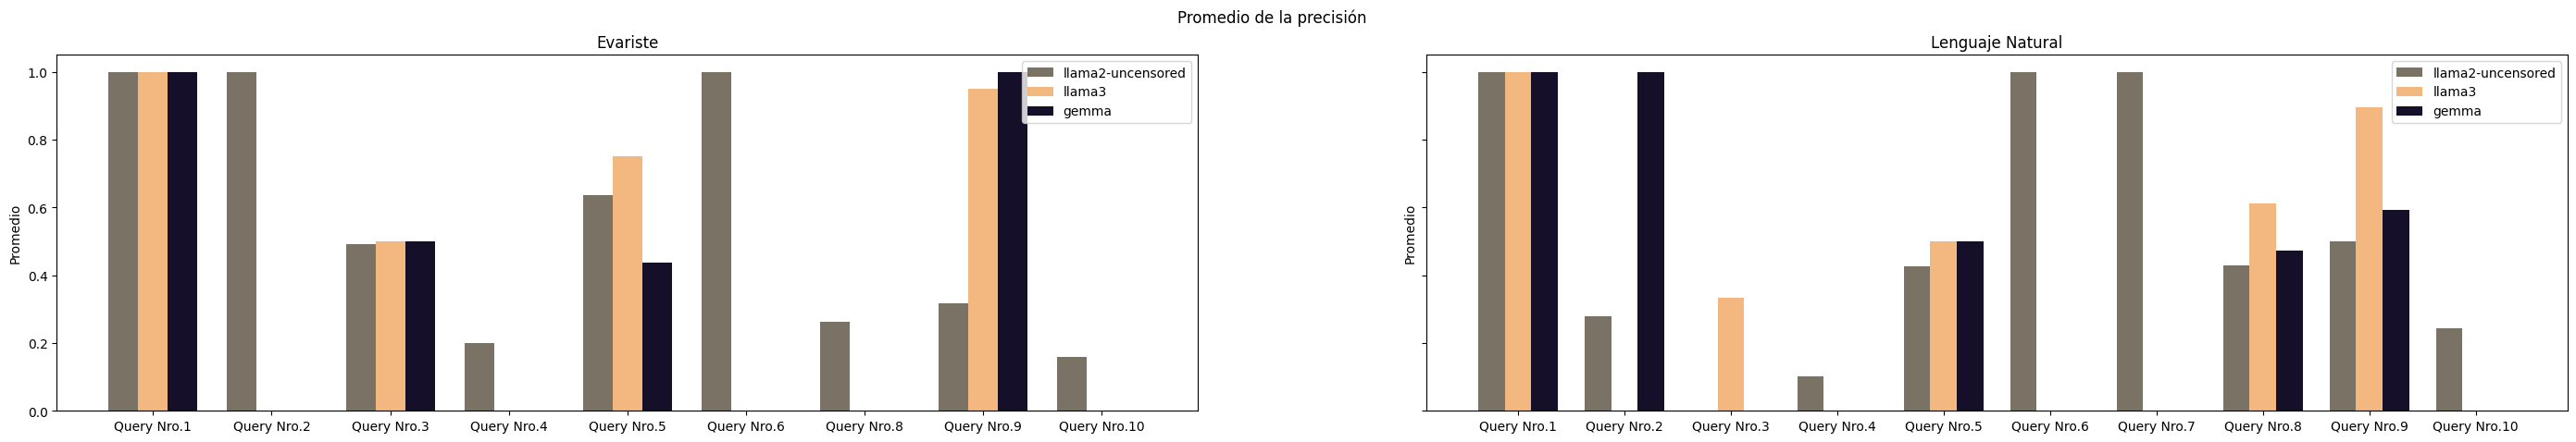

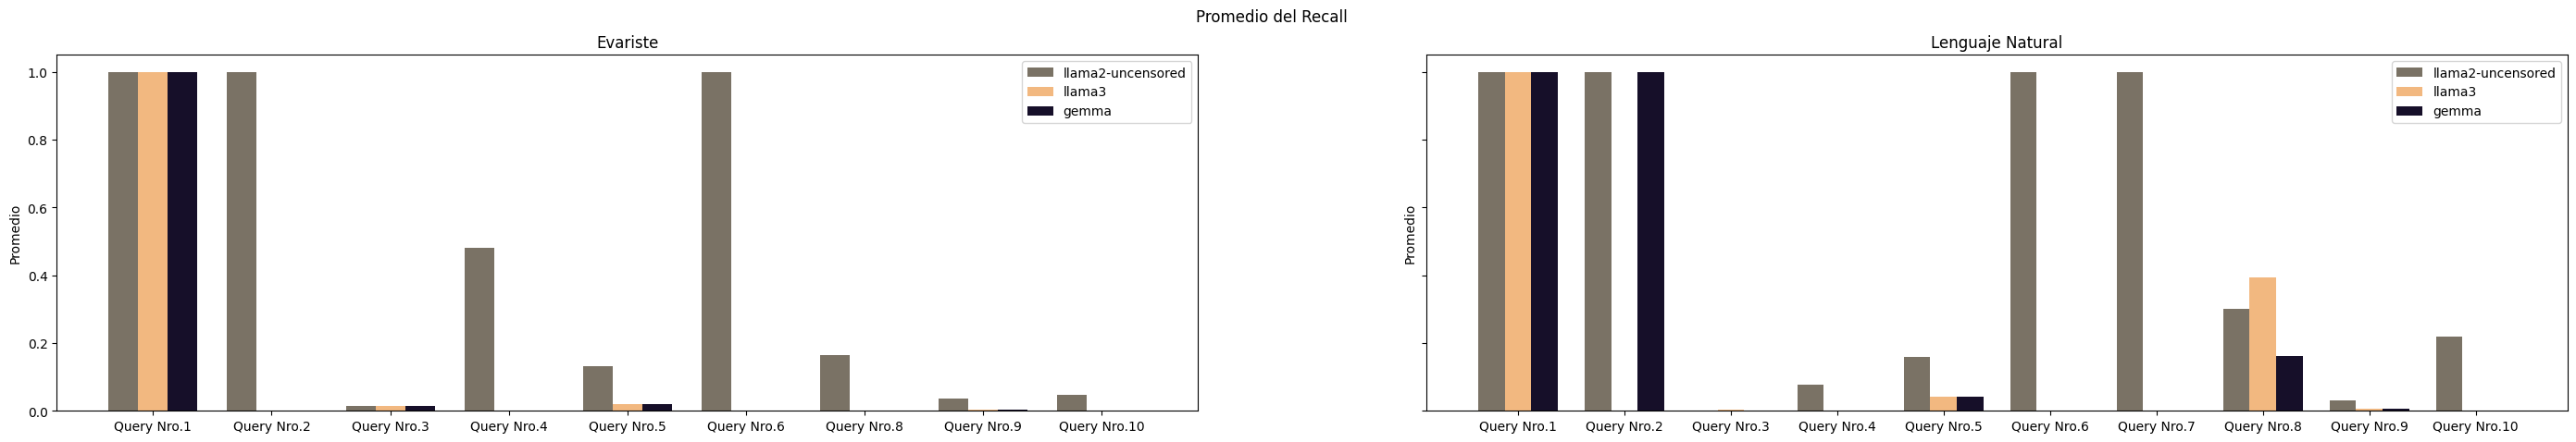

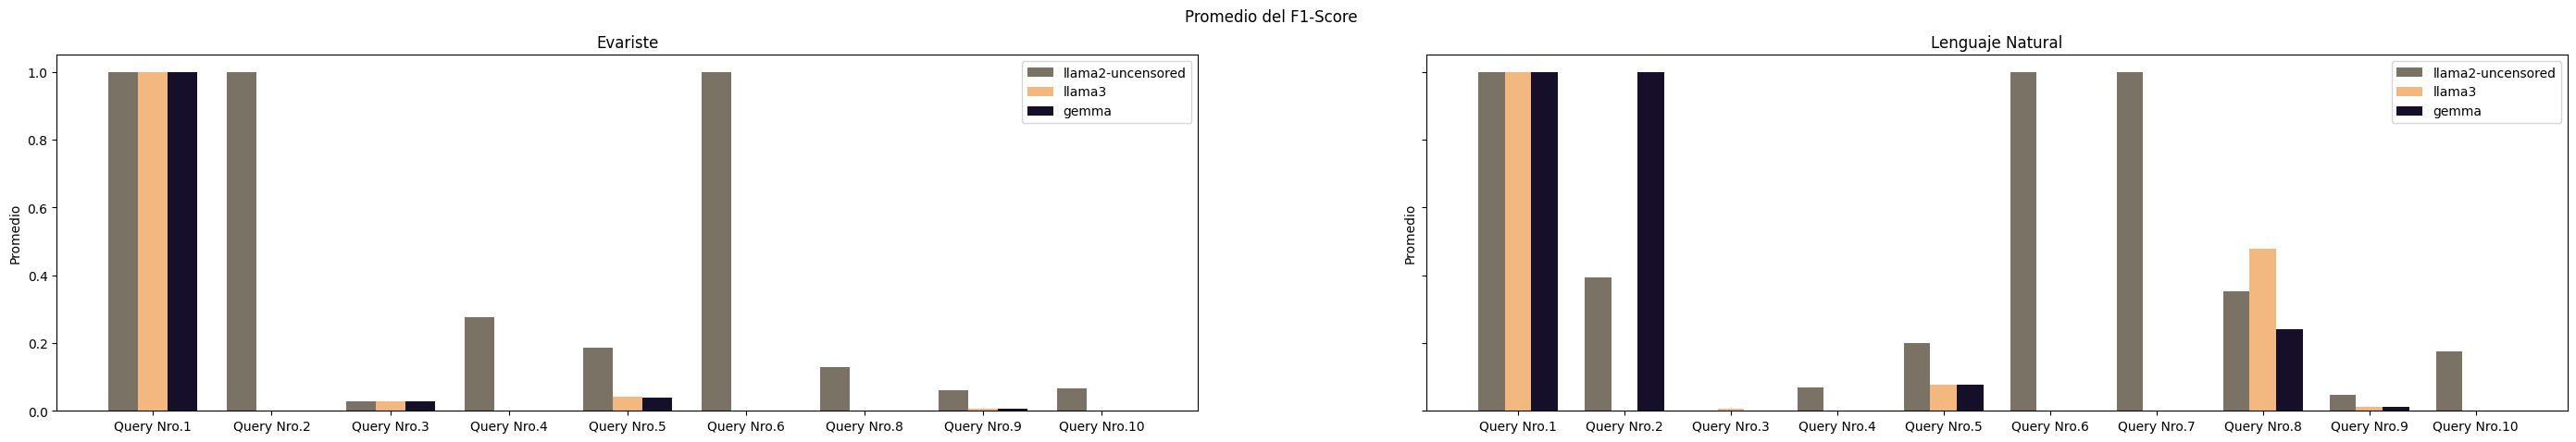

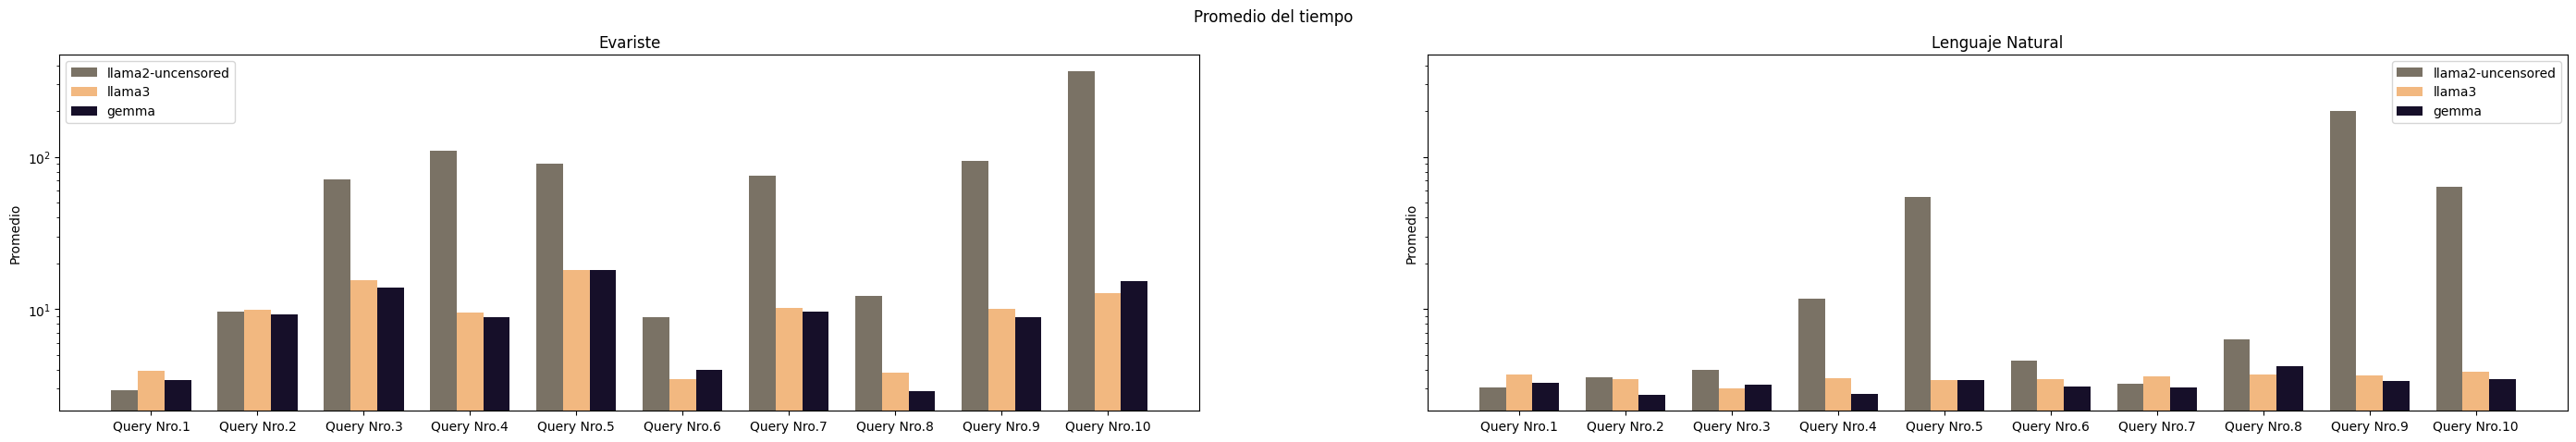

In [71]:
df_evariste = pd.read_excel('./resultados/metricas/queries/resumen_mk2.xlsx')
df_ln = pd.read_excel('./resultados/metricas/ln/resumen_mk2.xlsx')
df_galois = pd.read_excel('./resultados/metricas/galois/resumen_mk2.xlsx')
colores_modelos = {'llama2-uncensored': '#7A7265',
            'llama3': '#F2B880',
            'gemma': '#160F29'}

barras_metricas_evariste = {}
barras_metricas_ln = {}
barras_metricas_galois = {}
metricas = ['precision', 'recall', 'f1', 'tiempo']
for df, barras in zip([df_evariste, df_ln, df_galois], [barras_metricas_evariste, barras_metricas_ln, barras_metricas_galois]):
    for metrica in metricas:
        barras[metrica] = {}
        for i, query in enumerate((df['query'].unique().tolist())):
            modelos = df['modelo'].unique().tolist()
            barras[metrica][i] = {'modelo': modelos}
            valores = []
            for modelo in modelos:
                nuevo_valor = df.loc[(df['modelo'] == modelo) & (df['query'] == query) & (df[metrica] != 0)][metrica].mean()
                valores.append(nuevo_valor if not np.isnan(nuevo_valor) else 0)
            
            barras[metrica][i]['valores'] = valores


barras_comparar = [barras_metricas_evariste, barras_metricas_ln]
titulos = ["Promedio de la precisión", "Promedio del Recall", "Promedio del F1-Score", "Promedio del tiempo"]
nombres = ["Evariste", "Lenguaje Natural"]
for metrica, titulo in zip(metricas, titulos):
    fig, axs = plt.subplots(1,2,figsize=(35,5), sharey=True)
    fig.suptitle(titulo)
    if metrica == 'tiempo': plt.yscale('log')
    else: plt.yscale('linear')
    
    for i, barras, nombre in zip(list(range(len(barras_comparar))),barras_comparar, nombres):
        grafica_barra_agrupada(barras[metrica], 
                            nombre, 
                            'Promedio', 
                            [f"Query Nro.{i +1}" for i in barras[metrica].keys()], 
                            colores_modelos, 
                            'valores',
                            fig,
                            axs[i],
                            'modelo',
                            )


## Comparación Por query y Solucion

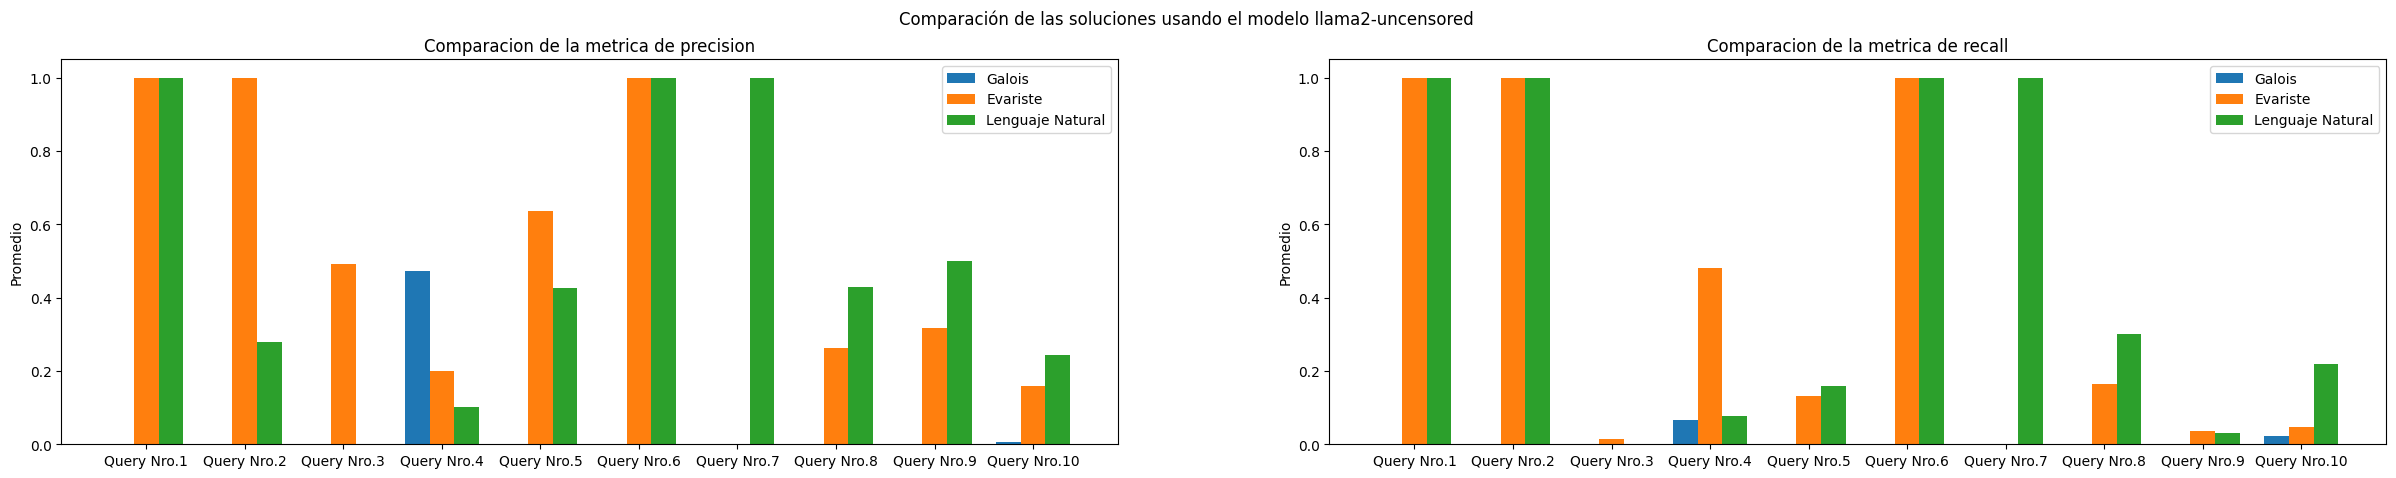

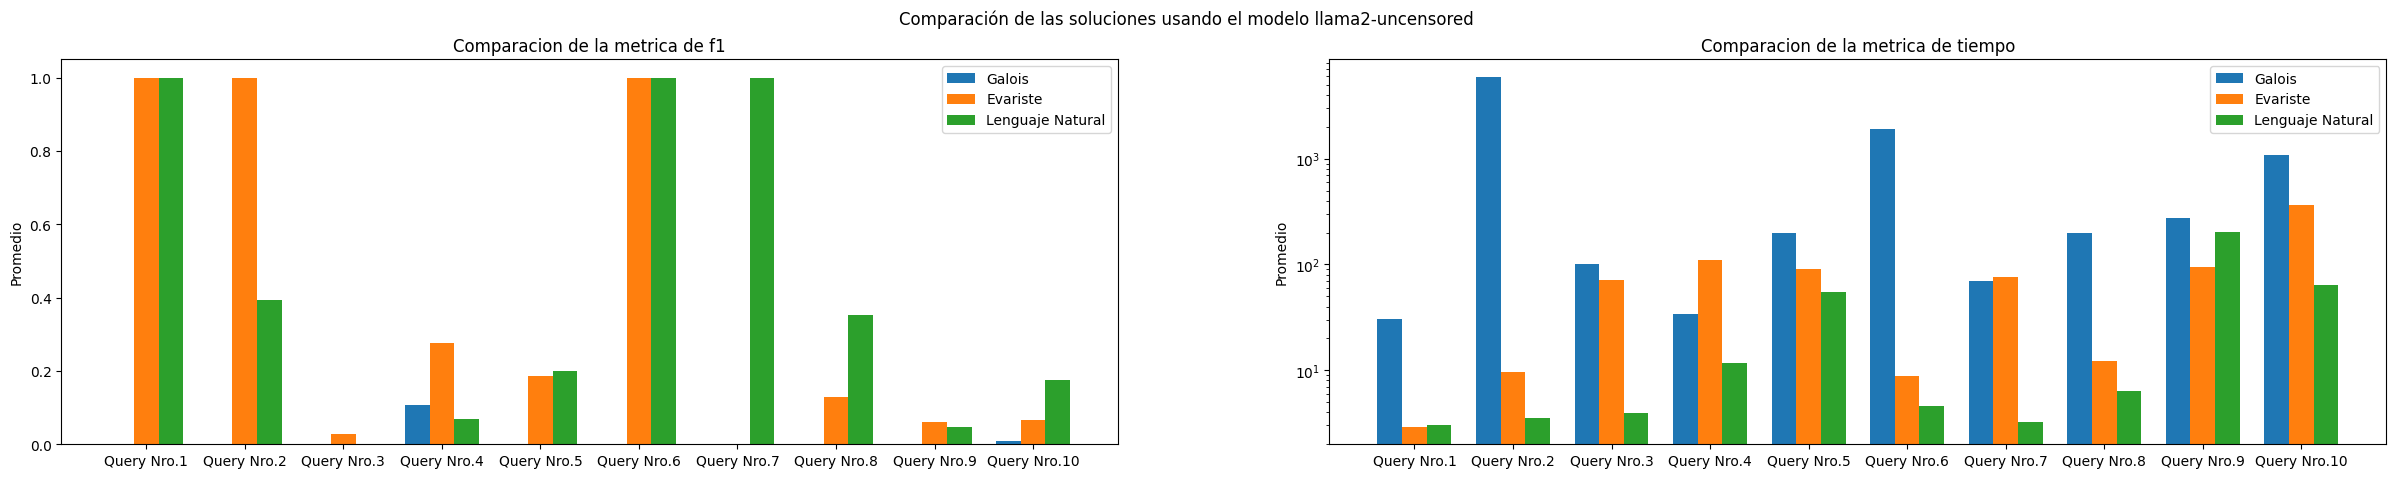

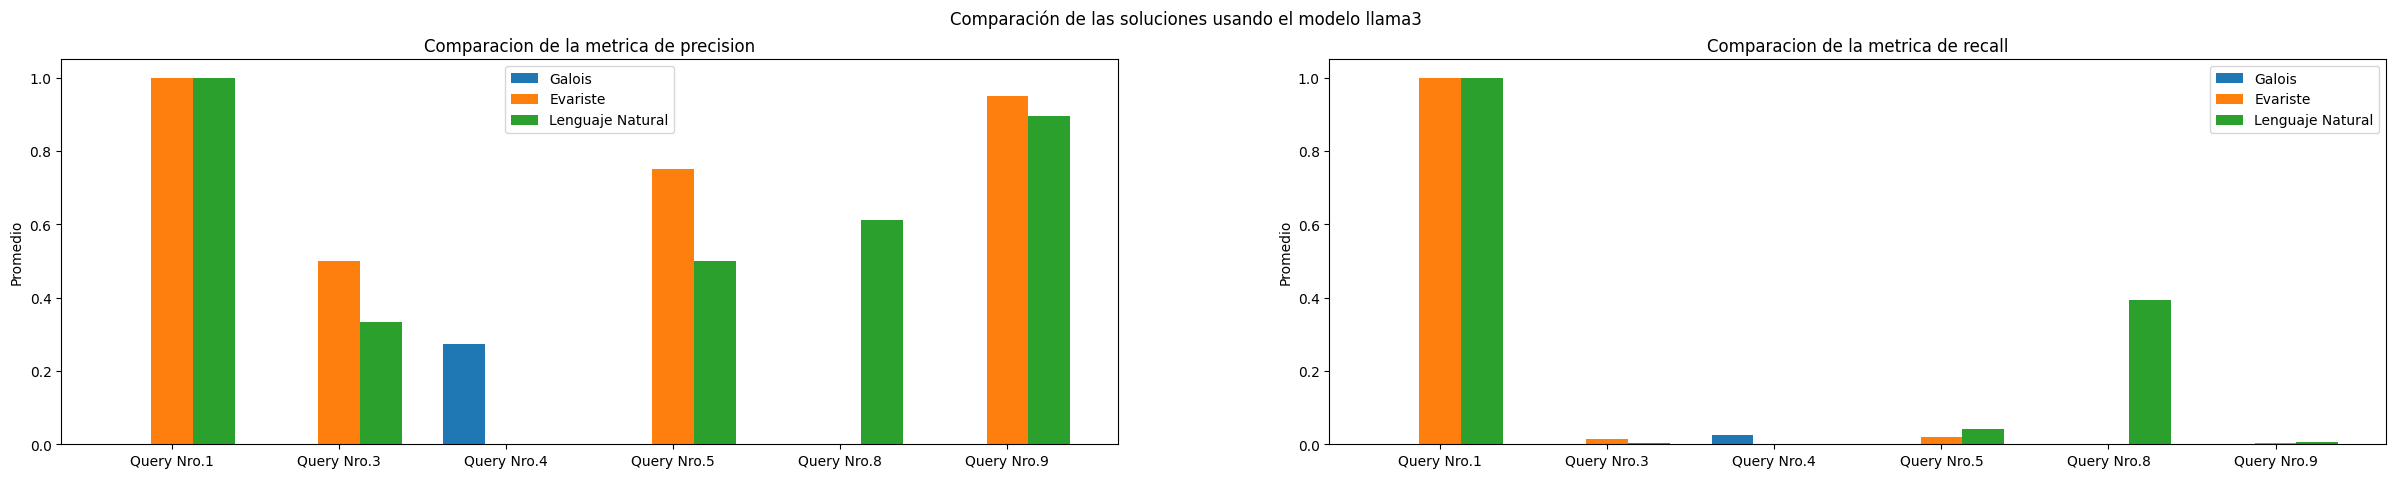

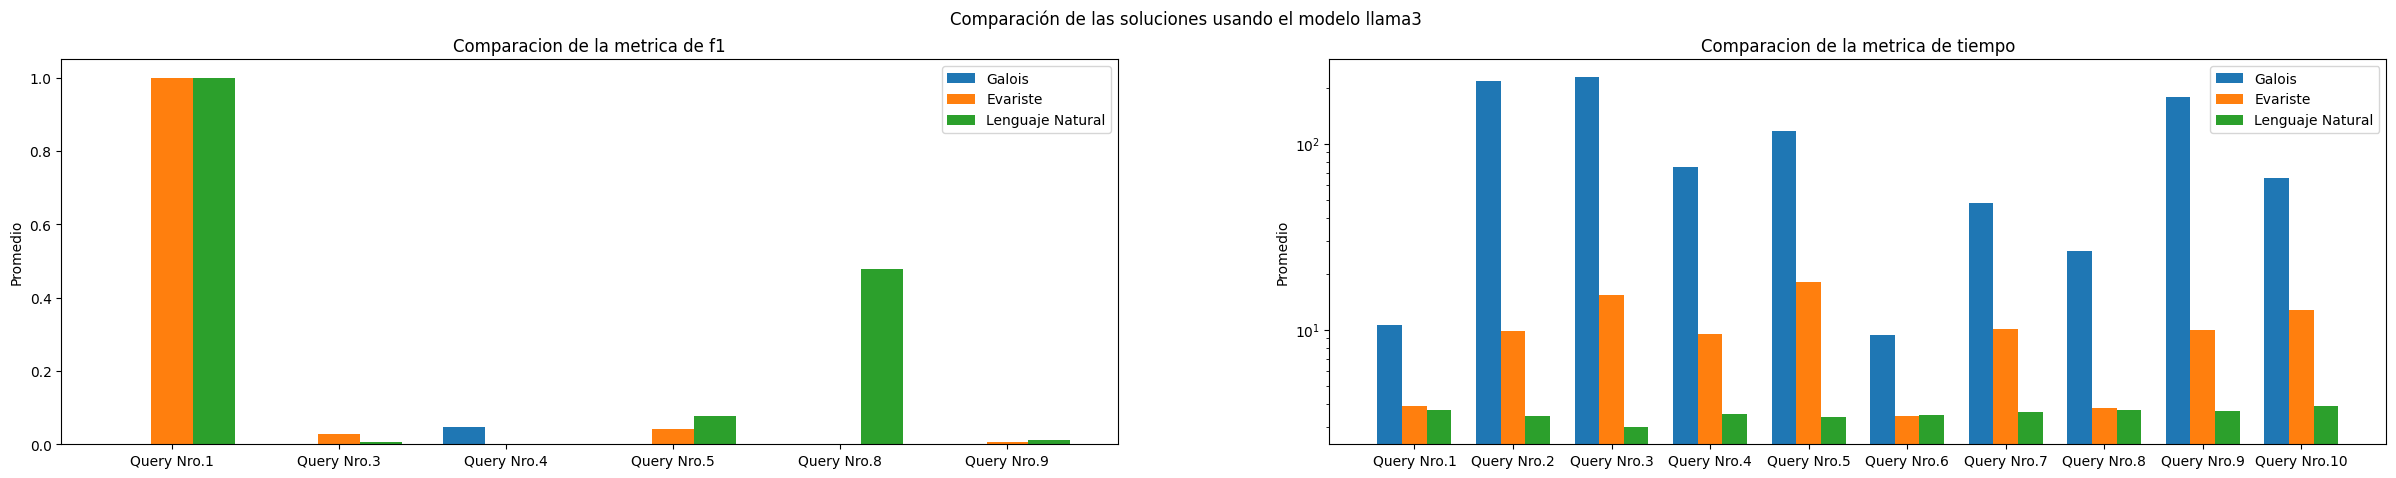

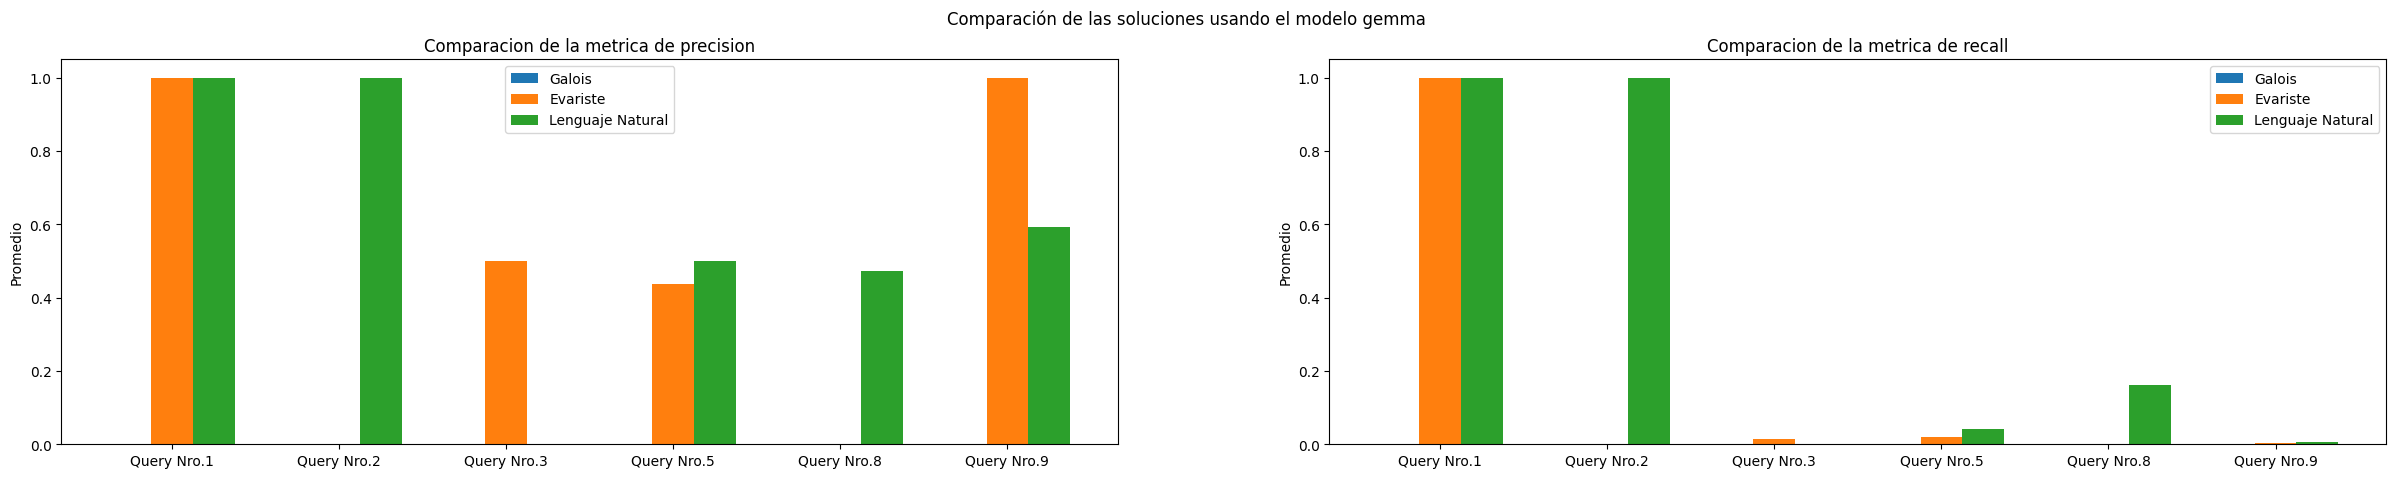

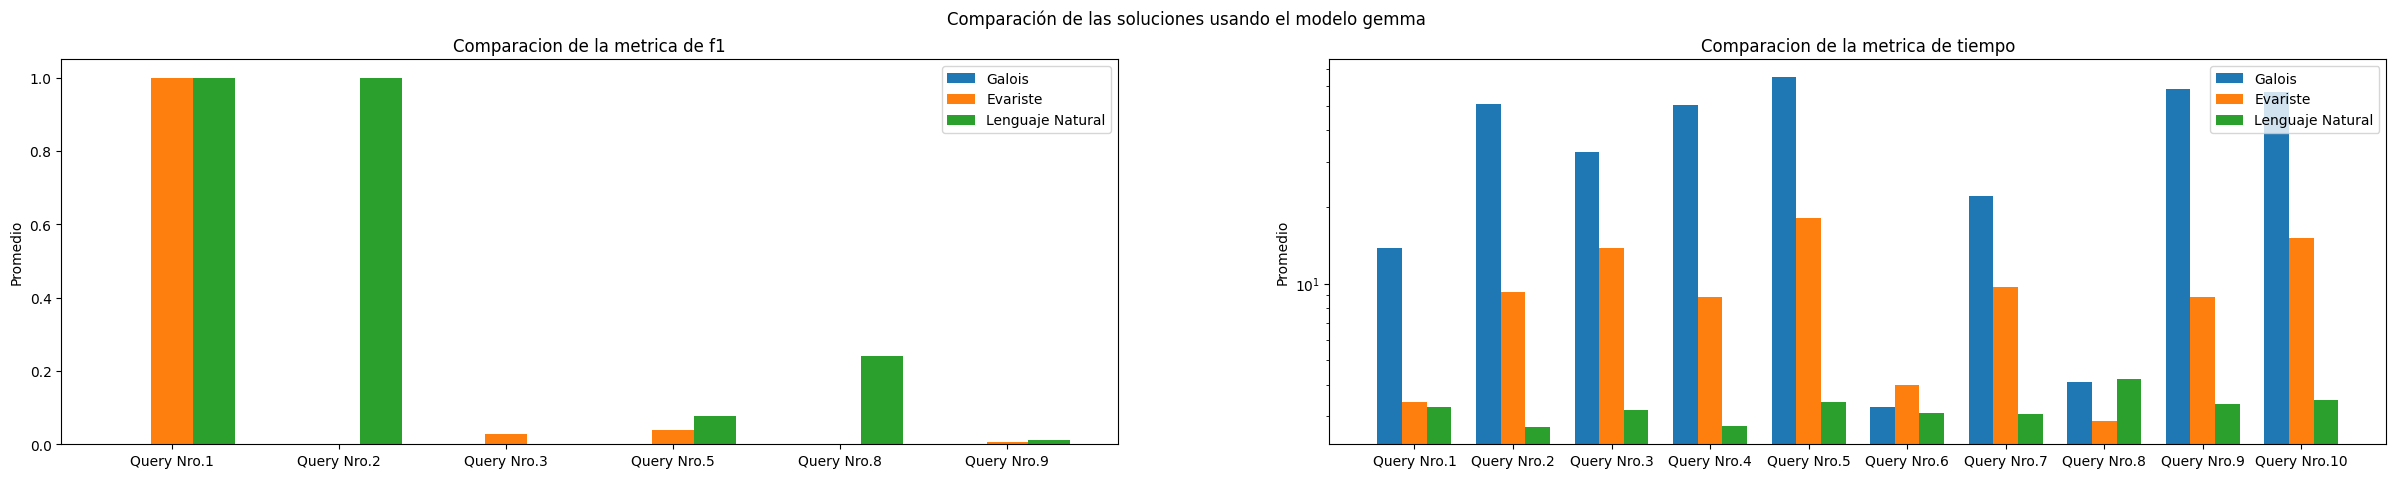

In [69]:
df_evariste = pd.read_excel('./resultados/metricas/queries/resumen_mk2.xlsx')
df_ln = pd.read_excel('./resultados/metricas/ln/resumen_mk2.xlsx')
df_galois = pd.read_excel('./resultados/metricas/galois/resumen_mk2.xlsx')

colores_soluciones = {
                      'Galois': 'tab:blue',
                      'Evariste': 'tab:orange',
                      'Lenguaje Natural': 'tab:green'}

soluciones = {
              'Galois': df_galois,
              'Evariste': df_evariste,
              'Lenguaje Natural': df_ln}

modelos = list(df_evariste['modelo'].unique())


# creamos la estructura de las barras
barras_metricas = {}
metricas = ['precision', 'recall', 'f1', 'tiempo']
queries = df_evariste['query'].unique()
for modelo in modelos:
    barras_metricas[modelo] = {}
    for metrica in metricas:
        barras_metricas[modelo][metrica] ={}
        for i, query in enumerate(queries):
            barras_metricas[modelo][metrica][i] = {'soluciones': list(soluciones.keys()), 'valores': []}
            for _, df in soluciones.items():
                nuevo_valor = df.loc[(df['modelo'] == modelo) & (df['query'] == query) & (df[metrica] != 0)][metrica].mean()

                barras_metricas[modelo][metrica][i]['valores'].append(nuevo_valor if not np.isnan(nuevo_valor) else 0)

# graficamos
titulo = "Comparación de las soluciones usando el modelo {modelo}"
subtitulo = "Comparacion de la metrica de {metrica}"
for modelo in modelos:
    metricas_mostradas = 0
    for metrica in metricas:
        if metricas_mostradas % 2 == 0:
            fig, axs = plt.subplots(1,2,figsize=(30,5))
            fig.suptitle(titulo.format(modelo=modelo))
            metricas_mostradas = 0

        if metrica == 'tiempo': plt.yscale('log')
        else: plt.yscale('linear')
        grafica_barra_agrupada(barras_metricas[modelo][metrica], 
                            subtitulo.format(metrica=metrica),
                            "Promedio",
                            [f"Query Nro.{i +1}" for i in range(len(queries))],
                            colores_soluciones,
                            'valores',
                            fig,
                            axs[metricas_mostradas],
                            'soluciones'
                            )
        metricas_mostradas += 1
    plt.show()